# Topic analysis

Measure political party similarities over time.
1. Based on political topics:
    For each word (e.g., economy) measure the word overlap of the 10-20 nearest neighbours between parties.

2. Based on name embeddings:
    Word overlap of the 10-20 nearest neighbours.


### 1. Overlap of nearest neighbors for selected topics (kaiti and dina)

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import string
import os
import datetime

from tqdm import tqdm
from gensim.models.word2vec import Word2Vec
from string import digits
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.interpolate import make_interp_spline, BSpline

tqdm.pandas()

Read tell_all_corrected.csv, group by period and political party and join speeches. 

In [5]:
%%time
data = pd.read_csv("../out_files/tell_all_cleaned.csv")

CPU times: user 26.7 s, sys: 1.41 s, total: 28.1 s
Wall time: 30.3 s


In [3]:
data.head(3)

member_name sitting_date parliamentary_period  \
0  κρητικος νικολαου παναγιωτης   03/07/1989             period 5   
1  κρητικος νικολαου παναγιωτης   03/07/1989             period 5   
2  κρητικος νικολαου παναγιωτης   03/07/1989             period 5   

  parliamentary_session parliamentary_sitting                 political_party  \
0             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   
1             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   
2             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   

                                     government member_region  \
0  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   
1  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   
2  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   

                                              roles member_gender  \
0  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   
1  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   
2  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   

  speaker_info                                             speech  
0   προεδρευων  παρακαλειται @sw γραμματεας βουλγαρακης @sw συ...  
1   προεδρευων  παρακαλειται @sw κυριος γραμματεας @sw συνοδευ...  
2   προεδρευων  κυριοι συναδελφοι παρακαλω @sw βουλη @sw εξουσ...

In [6]:
data = data.drop(data[(data.political_party != 'νεα δημοκρατια') &
                     (data.political_party != 'κομμουνιστικο κομμα ελλαδας') &
                     (data.political_party != 'πανελληνιο σοσιαλιστικο κινημα') &
                     (data.political_party != 'συνασπισμος ριζοσπαστικης αριστερας')].index)

In [7]:
data['sitting_date'] = pd.to_datetime(data['sitting_date'])
data['year'] = data['sitting_date'].apply(lambda x: x.year)
data.head(3)

member_name sitting_date parliamentary_period  \
0  κρητικος νικολαου παναγιωτης   1989-03-07             period 5   
1  κρητικος νικολαου παναγιωτης   1989-03-07             period 5   
2  κρητικος νικολαου παναγιωτης   1989-03-07             period 5   

  parliamentary_session parliamentary_sitting                 political_party  \
0             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   
1             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   
2             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   

                                     government member_region  \
0  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   
1  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   
2  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   

                                              roles member_gender  \
0  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   
1  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   
2  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   

  speaker_info                                             speech  year  
0   προεδρευων  παρακαλειται @sw γραμματεας βουλγαρακης @sw συ...  1989  
1   προεδρευων  παρακαλειται @sw κυριος γραμματεας @sw συνοδευ...  1989  
2   προεδρευων  κυριοι συναδελφοι παρακαλω @sw βουλη @sw εξουσ...  1989

In [6]:
%%time
grouped_data = data[data['speech'].notna()]

grouped_data = grouped_data.groupby(['year', 'political_party'])['speech'].progress_apply('. '.join).reset_index() # add missing dot from end of sentence
grouped_data['tokenised_speech'] = grouped_data.speech.progress_apply(lambda x: [sent.split(' ') for sent in x.split('.')])
grouped_data['tokenised_speech'] = grouped_data.tokenised_speech.progress_apply(lambda x: [token for token in x if token!='' and token!=' '])
grouped_data = grouped_data
grouped_data

100%|██████████| 106/106 [00:03<00:00, 33.19it/s]


CPU times: user 1min 3s, sys: 2min 1s, total: 3min 5s
Wall time: 13min 9s


year                      political_party  \
0    1989                       νεα δημοκρατια   
1    1989       πανελληνιο σοσιαλιστικο κινημα   
2    1990                       νεα δημοκρατια   
3    1990       πανελληνιο σοσιαλιστικο κινημα   
4    1991          κομμουνιστικο κομμα ελλαδας   
..    ...                                  ...   
101  2019                       νεα δημοκρατια   
102  2019  συνασπισμος ριζοσπαστικης αριστερας   
103  2020          κομμουνιστικο κομμα ελλαδας   
104  2020                       νεα δημοκρατια   
105  2020  συνασπισμος ριζοσπαστικης αριστερας   

                                                speech  \
0    κυριες @sw κυριοι συναδελφοι αναλαμβανοντας @s...   
1    παρακαλειται @sw γραμματεας βουλγαρακης @sw συ...   
2    κυριοι συναδελφοι αρχιζει @sw συνεδριαση. κυρι...   
3    @sw @sw αντιρρηση @sw @sw συνεννοηθουμε.@sw @s...   
4    κυριε προεδρε @sw κυριοι βουλευτες @sw παρον ν...   
..                                                 ...   
101  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...   
102  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...   
103  ευχαριστω κυριε προεδρε.@sw λογος @sw ερωτηση ...   
104  κυριες @sw κυριοι συναδελφοι αρχιζει @sw συνεδ...   
105  @sw αυξησεις εισφορων. @sw μειωσεις.@sw χριστο...   

                                      tokenised_speech  
0    [[κυριες, @sw, κυριοι, συναδελφοι, αναλαμβανον...  
1    [[παρακαλειται, @sw, γραμματεας, βουλγαρακης, ...  
2    [[κυριοι, συναδελφοι, αρχιζει, @sw, συνεδριαση...  
3    [[@sw, @sw, αντιρρηση, @sw, @sw, συνεννοηθουμε...  
4    [[κυριε, προεδρε, @sw, κυριοι, βουλευτες, @sw,...  
..                                                 ...  
101  [[κυριες, @sw, κυριοι, συναδελφοι, αρχιζει, @s...  
102  [[κυριες, @sw, κυριοι, συναδελφοι, αρχιζει, @s...  
103  [[ευχαριστω, κυριε, προεδρε], [@sw, λογος, @sw...  
104  [[κυριες, @sw, κυριοι, συναδελφοι, αρχιζει, @s...  
105  [[@sw, αυξησεις, εισφορων], [, @sw, μειωσεις],...  

[106 rows x 4 columns]

In [7]:
parties_selected = ['πανελληνιο σοσιαλιστικο κινημα', 'νεα δημοκρατια', 'κομμουνιστικο κομμα ελλαδας',
                   'συνασπισμος ριζοσπαστικης αριστερας']

In [8]:
print(grouped_data.speech.iloc[0][:1000])

κυριες @sw κυριοι συναδελφοι αναλαμβανοντας @sw προεδρια @sw σωματος @sw @sw @sw αρχην @sw ευχαριστησω @sw @sw ψηφισαν.@sw @sw @sw @sw ευχαριστησω @sw @sw @sw @sw @sw εψηφισαν.@sw τεκμηριο @sw δημοκρατικοτητος @sw @sw @sw @sw νομιμοτητος @sw εκλογης @sw @sw @sw @sw θετικες @sw @sw @sw @sw αρνητικες ψηφοι.@sw @sw @sw @sw @sw @sw @sw @sw @sw @sw πιστοποιουν @sw @sw συστημα λειτουργει.@sw προεδρος @sw βουλης @sw @sw @sw προσωπο υπερκομματικο.προερχεται @sw @sw παραταξη.@sw ρολος @sw @sw καλειται @sw παιξει @sw πλαισιο @sw πολιτευματος @sw υπερκομματικος αντικειμενικος @sw αμεροληπτος.@sw @sw απαιτησεις @sw @sw ρολου @sw αποφασισμενος @sw ανταποκριθω @sw ακεραιο.@sw ξερω @sw @sw διαρκεσει @sw θητεια @sw @sw @sw @sw τερματισθει @sw μεγαλυτερη ικανοποιηση @sw μενα @sw @sw @sw αναγνωρισθει @sw @sw @sw πτερυγες @sw κοινοβουλιου @sw @sw μεροληπτησα @sw @sw @sw @sw κομματος.αποδιδω αλλωστε πρωταρχικη σημασια @sw ομαλη @sw αποτελεσματικη λειτουργια @sw κοινοβουλευτισμου.@sw ορος @sw @sw ουκ @sw @

In [9]:
grouped_data.head(3)

year                 political_party  \
0  1989                  νεα δημοκρατια   
1  1989  πανελληνιο σοσιαλιστικο κινημα   
2  1990                  νεα δημοκρατια   

                                              speech  \
0  κυριες @sw κυριοι συναδελφοι αναλαμβανοντας @s...   
1  παρακαλειται @sw γραμματεας βουλγαρακης @sw συ...   
2  κυριοι συναδελφοι αρχιζει @sw συνεδριαση. κυρι...   

                                    tokenised_speech  
0  [[κυριες, @sw, κυριοι, συναδελφοι, αναλαμβανον...  
1  [[παρακαλειται, @sw, γραμματεας, βουλγαρακης, ...  
2  [[κυριοι, συναδελφοι, αρχιζει, @sw, συνεδριαση...

In [10]:
grouped_data.to_csv('../out_files/speeches_split_hamilton.csv')

In [11]:
grouped_data = pd.read_csv("../out_files/speeches_split_hamilton.csv")

### Implementation of local neighborhood measure for semantic shift from Hamilton's paper
Section 2.1 https://www.aclweb.org/anthology/D16-1229/

#### Update  models with specified values for hyperparameters

In [23]:
%%time
# !! run once !!

from tqdm import tqdm
from gensim.models import Word2Vec
import nltk

for party in grouped_data.political_party.unique():
    for year in grouped_data.year.unique():
        if not grouped_data['tokenised_speech'].loc[(grouped_data.political_party == party) &
                     (grouped_data.year == year)].empty:
            per_period_speeches = grouped_data['tokenised_speech'].loc[(grouped_data.political_party == party) &
                     (grouped_data.year == year)].values#[0]
            print(per_period_speeches[0][:100])
            try:
                print(party, period)
                model = Word2Vec(sentences=per_period_speeches, size=300, window=5, min_count=20, workers=1)
                model.save(f"../wordmodels_cleaned/PERperiod_PERparty/{party}_period{period}.mdl")
            except:
                continue

[['κυριες', '@sw', 'κυριοι', 'συναδελφοι', 'αναλαμβανοντας', '@sw', 'προεδρια', '@sw', 'σωματος', '@
[['κυριοι', 'συναδελφοι', 'αρχιζει', '@sw', 'συνεδριαση'], ['', 'κυριοι', 'συναδελφοι', '@sw', 'προχ
[['κυριοι', 'συναδελφοι', 'αρχιζει', '@sw', 'συνεδριαση'], ['@sw', '@sw', '@sw', 'ευχηθω', '@sw', '@
[['κυριοι', 'συναδελφοι', 'αρχιζει', '@sw', 'συνεδριαση'], ['ευχομαι', '@sw', '@sw', '@sw', 'συναδελ
[['κυριοι', 'συναδελφοι', 'αρχιζει', '@sw', 'συνεδριαση'], ['@sw', '@sw', '@sw', 'ευχηθω', '@sw', '@
[['κυριε', 'προεδρε', 'συνεννοηθηκα', '@sw', '@sw', 'κυριο', 'υπουργο', '@sw', '@sw', 'ερωτηση', '@s
[['κυριε', 'προεδρε', 'αντιλαμβανεστε', '@sw', '@sw', 'περισσοτεροι', 'συναδελφοι', '@sw', '@sw', '@
[['κυριε', 'προεδρε', 'κυριες', '@sw', 'κυριοι', 'συναδελφοι', '@sw', '@sw', 'σειρα', '@sw', '@sw', 
[['κυριες', 'καικυριοι', 'συναδελφοι', '@sw', '@sw', 'βαρυτατο', 'εργο', '@sw', 'επιτελεσουμε'], ['κ
[['πρωτοι', '@sw', '@sw', 'ξεκινησαμε', '@sw'], ['', '@sw', '@sw', '@sw', 'προτεινετε', '@s

In [24]:
def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]

In [25]:
df = grouped_data
df.sort_values(by='year')
years = sorted(list(df.year.unique()))
year_pairs = step_one_pairs(years)
pd.Series(year_pairs).unique()

array([(1989, 1990), (1990, 1991), (1991, 1992), (1992, 1993),
       (1993, 1994), (1994, 1996), (1996, 1997), (1997, 1998),
       (1998, 1999), (1999, 2000), (2000, 2001), (2001, 2002),
       (2002, 2003), (2003, 2004), (2004, 2005), (2005, 2006),
       (2006, 2007), (2007, 2008), (2008, 2009), (2009, 2010),
       (2010, 2011), (2011, 2012), (2012, 2013), (2013, 2014),
       (2014, 2015), (2015, 2016), (2016, 2017), (2017, 2018),
       (2018, 2019), (2019, 2020)], dtype=object)

In [26]:
vouliwatch_topics = ['αγροτικη', 'αγροτικα', 'αγροτες', 
          'αναπτυξη', 'επενδυσεις', 'επενδυσεων',
          'ασφαλιστικο', 'εργασια', 'εργασιακα', 'δικαιωματα', 'συμβαση', 'συλλογικη', 'μισθος', 'βασικος', 'ημιαπασχοληση', 'brain', 'οαεδ',
          'δικαιοσυνη', 'διαφανεια', 'υιοθεσια',
          'εθνικη', 'αμυνα',
          'εξωτερικη', 'διεθνεις',
          'ναυτιλια','νησια','υδροδοτηση','αλιεια',
          'οικονομια', 'αφορολογητο', 'αποκεντρωση', 'φπα', 'επιχειρησεις', 'φορολογικα', 
          'παιδεια', 'ερευνα', 'προσχολικη', 'ασυλο', 'πανεπιστημιακο', 'δευτεροβαθμια', 'πρωτοβαθμια', 'ανωτατη', 'δημοσια', 'ιδιωτικη', 'σχολες',
          'περιβαλλον', 'ενεργεια', 
          'συστημα',
          'πολιτισμος', 'αθλητισμος', 'πολιτισμο', 'αθλητισμου',
          'προστασια', 'αστυνομια', 'κοκ',
          'προσφυγικο', 'μεταναστευτικο', 
          'τουρισμος', 'τουριστικης', 'τουρισμου',
          'υγεια', 'προνοια', 'επιδοματα', 'επιδομα', 'επιδοματων',
          'υποδομες', 'μεταφορες', 'αναπλαση', #'μμμ',
          'μειωση', 'αυξηση', 'συνταξη', 'πγδμ', 'προσληψεις', 'εκασ', 'οσε', 'συγκοινωνιες', 'νομοσχεδιο', #'ομοφυλα', 'εοπυυ'
         ]

In [27]:
year_pairs[0][0]

1989

In [28]:
m = Word2Vec.load("../wordmodels_cleaned/PERperiod_PERparty/νεα δημοκρατια_period2020.mdl")
print([w for w,s in m.wv.most_similar(positive=['οικονομια'], topn=25)])

['κοινωνια', 'πολιτεια', 'κρατος', 'οικογενεια', 'ελληνα', 'μαχη', 'περιβαλλον', 'πανδημια', 'αυτοδιοικηση', 'εποχη', 'τουρισμος', 'ταξη', 'πραγματικη', 'συνεπειες', 'γενια', 'αγροτικη', 'στηριξουμε', 'παγκοσμια', 'τουρισμο', 'υγεια', 'επιχειρηματικοτητα', 'ζωη', 'καθημερινοτητα', 'ασφαλεια', 'επιτυχια']


In [29]:
# find the topics that exist in all years per party

def all_years_topic_presence(party):
    filtered_vouliwatch_topics=vouliwatch_topics[:]

    for topic in vouliwatch_topics:
        #print(party)
        if party == 'πανελληνιο σοσιαλιστικο κινημα':
            max_year = 2016
        else:
            max_year = max(grouped_data.loc[grouped_data.political_party==party].year.unique())+1
        years = range(max(min(grouped_data.loc[grouped_data.political_party==party].year.unique()), 2000),max_year)
        #print(years)
        for year in years:
            try:
                m = Word2Vec.load(f"../wordmodels_cleaned/PERperiod_PERparty/{party}_period{year}.mdl")
                count = m.wv.vocab[topic].count
            except:
                try:
                    filtered_vouliwatch_topics.remove(topic)
                    #print(filtered_vouliwatch_topics)
                except:
                    continue
                continue

            if (count < 1):
                try:
                    filtered_vouliwatch_topics.remove(topic)
                    #print(filtered_vouliwatch_topics)
                except:
                    continue
                    
    return filtered_vouliwatch_topics

In [30]:
%%time
present_topics_dict = {}
for party in parties_selected:
    present_topics_dict[party] = all_years_topic_presence(party)
    print(len(present_topics_dict[party]), party)

21 κομμουνιστικο κομμα ελλαδας
22 συνασπισμος ριζοσπαστικης αριστερας
36 νεα δημοκρατια
20 πανελληνιο σοσιαλιστικο κινημα
CPU times: user 7min 59s, sys: 31.2 s, total: 8min 30s
Wall time: 8min 29s


In [31]:
syriza_present_topics = present_topics_dict['συνασπισμος ριζοσπαστικης αριστερας']
kke_present_topics = present_topics_dict['κομμουνιστικο κομμα ελλαδας']
nd_present_topics = present_topics_dict['νεα δημοκρατια']
pasok_present_topics = present_topics_dict['πανελληνιο σοσιαλιστικο κινημα']

In [32]:
%%time
similarities_2nd_order = []

for party in parties_selected:
    print(party)
    for pair in year_pairs:
        print(pair)
        for topic in present_topics_dict[party]:
            try:
                m1 = Word2Vec.load(f"../wordmodels_cleaned/PERperiod_PERparty/{party}_period{pair[0]}.mdl")
                m2 = Word2Vec.load(f"../wordmodels_cleaned/PERperiod_PERparty/{party}_period{pair[1]}.mdl")
            except:
                continue
    
            #union of neighbors in two points in time
            try: # not all words exist in vocabulary
                neighbors_t1 = [w for w,s in m1.wv.most_similar(positive=[topic], topn=25)]
                neighbors_t2 = [w for w,s in m2.wv.most_similar(positive=[topic], topn=25)]
            except:
                continue
            neighbors_t1_t2 = list(set(neighbors_t1+neighbors_t2))

            neighbors_union=[]
            # keep neighbors that are included in the compared model vocabularies
            for neighbor in neighbors_t1_t2:
                if (neighbor in m1.wv.vocab) and (neighbor in m2.wv.vocab):
                    neighbors_union.append(neighbor)
        #     print('Union of neighbors: ', str(len(neighbors_union)))
    
            # similarity vector for time point 1 (t1)
            # each element is the cosine similarity of topic vector in t1 and each neighbor from neighbors_union
            similarity_vector_t1 = []
            topic_vector_t1 = m1.wv[topic]
            for nn in neighbors_union:
                neighbor_vector = m1.wv[nn]
                similarity_vector_t1.append(cosine_similarity(X=topic_vector_t1.reshape(1,-1), Y=neighbor_vector.reshape(1,-1))[0][0])
        #     print(len(similarity_vector_t1))
    
            # similarity vector for time point 2 (t2)
            # each element is the cosine similarity of topic vector in t2 and each neighbor from neighbors_union
            similarity_vector_t2 = []
            topic_vector_t2 = m2.wv[topic]
            for nn in neighbors_union:
                neighbor_vector = m2.wv[nn]
                similarity_vector_t2.append(cosine_similarity(X=topic_vector_t2.reshape(1,-1), Y=neighbor_vector.reshape(1,-1))[0][0])
        #     print(len(similarity_vector_t2))

            #testing
        #     print(similarity_vector_t1)
        #     print(np.array([similarity_vector_t1]))
            # print(np.array(similarity_vector_t2).reshape(-1, 1))

            # final cosine between cosines/ similarity vectors for t1 and t2
            result = cosine_similarity(np.array([similarity_vector_t1]),
                                       np.array([similarity_vector_t2])
                                      )[0][0]

            similarities_2nd_order.append([topic, party, f"{pair[0]} - {pair[1]}", result, len(neighbors_union), neighbors_t1, neighbors_t2])
        #     break


df_similarities_2nd_order = pd.DataFrame(data=similarities_2nd_order, columns=['topic', 'parties', 'time_points', 'cosine_similarity', 'neighbors_union', 'neighbors_before', 'neighbors_after'])
df_similarities_2nd_order
        #df_similarities_2nd_order = df_similarities_2nd_order.sort_values('cosine_similarity', ascending=True).reset_index(drop=True)
        #print(df_similarities_2nd_order.head(5))
        #df_similarities_2nd_order.describe()

κομμουνιστικο κομμα ελλαδας
(1989, 1990)
(1990, 1991)
(1991, 1992)
(1992, 1993)
(1993, 1994)
(1994, 1996)
(1996, 1997)
(1997, 1998)
(1998, 1999)
(1999, 2000)
(2000, 2001)
(2001, 2002)
(2002, 2003)
(2003, 2004)
(2004, 2005)
(2005, 2006)
(2006, 2007)
(2007, 2008)
(2008, 2009)
(2009, 2010)
(2010, 2011)
(2011, 2012)
(2012, 2013)
(2013, 2014)
(2014, 2015)
(2015, 2016)
(2016, 2017)
(2017, 2018)
(2018, 2019)
(2019, 2020)
συνασπισμος ριζοσπαστικης αριστερας
(1989, 1990)
(1990, 1991)
(1991, 1992)
(1992, 1993)
(1993, 1994)
(1994, 1996)
(1996, 1997)
(1997, 1998)
(1998, 1999)
(1999, 2000)
(2000, 2001)
(2001, 2002)
(2002, 2003)
(2003, 2004)
(2004, 2005)
(2005, 2006)
(2006, 2007)
(2007, 2008)
(2008, 2009)
(2009, 2010)
(2010, 2011)
(2011, 2012)
(2012, 2013)
(2013, 2014)
(2014, 2015)
(2015, 2016)
(2016, 2017)
(2017, 2018)
(2018, 2019)
(2019, 2020)
νεα δημοκρατια
(1989, 1990)
(1990, 1991)
(1991, 1992)
(1992, 1993)
(1993, 1994)
(1994, 1996)
(1996, 1997)
(1997, 1998)
(1998, 1999)
(1999, 2000)
(2000, 2001

topic                         parties  time_points  \
0        αγροτες     κομμουνιστικο κομμα ελλαδας  1991 - 1992   
1       αναπτυξη     κομμουνιστικο κομμα ελλαδας  1991 - 1992   
2     επενδυσεων     κομμουνιστικο κομμα ελλαδας  1991 - 1992   
3     δικαιωματα     κομμουνιστικο κομμα ελλαδας  1991 - 1992   
4        συμβαση     κομμουνιστικο κομμα ελλαδας  1991 - 1992   
...          ...                             ...          ...   
2445   προστασια  πανελληνιο σοσιαλιστικο κινημα  2014 - 2015   
2446      μειωση  πανελληνιο σοσιαλιστικο κινημα  2014 - 2015   
2447      αυξηση  πανελληνιο σοσιαλιστικο κινημα  2014 - 2015   
2448     συνταξη  πανελληνιο σοσιαλιστικο κινημα  2014 - 2015   
2449  νομοσχεδιο  πανελληνιο σοσιαλιστικο κινημα  2014 - 2015   

      cosine_similarity  neighbors_union  \
0              0.996298               40   
1              0.983534               42   
2              0.993282               30   
3              0.996340               42   
4              0.984949               38   
...                 ...              ...   
2445           0.943075               37   
2446           0.976734               41   
2447           0.970741               41   
2448           0.986270               25   
2449           0.921393               41   

                                       neighbors_before  \
0     [ελεγε, επαγγελμα, προγραμματα, αρμοδιοτητες, ...   
1     [διυλιστηρια, φαρμακου, συνολικα, μεγαλο, πορε...   
2     [εισοδηματος, δαπανες, δημοσιων, ποσοστο, υπηρ...   
3     [εθνικη, οικονομικες, προιοντων, οργανωσεις, α...   
4     [ελεγχος, διαφημιση, παραγοντες, κομμα, πατε, ...   
...                                                 ...   
2445  [πολιτη, τομεα, μοντελο, κρατους, στοχο, μειωσ...   
2446  [αυξηση, ελλειμμα, αξιοποιηση, εσοδα, ταμειο, ...   
2447  [μειωση, ελλειμμα, ταμειο, αεπ, 50, 2011, αξιο...   
2448  [αττικη, κοινοτητες, φευγει, προστιμο, οργανισ...   
2449  [διαταξη, συζηταμε, πρωτοβουλια, συζητηση, νομ...   

                                        neighbors_after  
0     [συνθηκες, επιπτωσεις, κοινωνια, γνωριζουν, εξ...  
1     [χωρες, χωρας, οικονομια, εργαζομενους, νατο, ...  
2     [προγραμματων, δαπανων, ποιοτητα, κερδων, περι...  
3     [στοχο, βιομηχανια, πολεμο, επιπεδο, απελευθερ...  
4     [δεχθουμε, απαντησετε, αρχη, δειτε, νομοσχεδιο...  
...                                                 ...  
2445  [ψηφισε, ταυτοχρονα, δανειου, καντε, καταργηση...  
2446  [ρευστοτητα, προτυπα, ελληνικα, μισθους, ταμει...  
2447  [φπα, εσοδων, ορους, παρουμε, καταθεσεις, ευρω...  
2448  [δημοσιων, χιλιαδες, 15, παρατασης, δικαιο, ελ...  
2449  [πασοκ, τροπολογια, κανετε, διοτι, λετε, νομιζ...  

[2450 rows x 7 columns]

In [33]:
df_similarities_2nd_order.to_csv('../out_files/hamilton_method_per_year.csv', index=False)

In [34]:
df_similarities_2nd_order = pd.read_csv('../out_files/hamilton_method_per_year.csv')

In [35]:
parties_selected = ['κομμουνιστικο κομμα ελλαδας', 'συνασπισμος ριζοσπαστικης αριστερας', 'νεα δημοκρατια',
                    'πανελληνιο σοσιαλιστικο κινημα']

In [36]:
df = df_similarities_2nd_order[['topic', 'parties', 'time_points', 'cosine_similarity']]
df

topic                         parties  time_points  \
0        αγροτες     κομμουνιστικο κομμα ελλαδας  1991 - 1992   
1       αναπτυξη     κομμουνιστικο κομμα ελλαδας  1991 - 1992   
2     επενδυσεων     κομμουνιστικο κομμα ελλαδας  1991 - 1992   
3     δικαιωματα     κομμουνιστικο κομμα ελλαδας  1991 - 1992   
4        συμβαση     κομμουνιστικο κομμα ελλαδας  1991 - 1992   
...          ...                             ...          ...   
2445   προστασια  πανελληνιο σοσιαλιστικο κινημα  2014 - 2015   
2446      μειωση  πανελληνιο σοσιαλιστικο κινημα  2014 - 2015   
2447      αυξηση  πανελληνιο σοσιαλιστικο κινημα  2014 - 2015   
2448     συνταξη  πανελληνιο σοσιαλιστικο κινημα  2014 - 2015   
2449  νομοσχεδιο  πανελληνιο σοσιαλιστικο κινημα  2014 - 2015   

      cosine_similarity  
0              0.996298  
1              0.983534  
2              0.993282  
3              0.996340  
4              0.984949  
...                 ...  
2445           0.943075  
2446           0.976734  
2447           0.970741  
2448           0.986270  
2449           0.921393  

[2450 rows x 4 columns]

In [37]:
df_parties_columns = df.pivot_table(index=['topic', 'time_points'], columns='parties', values='cosine_similarity').reset_index()
df_parties_columns#.loc[(temp.topic == 'αγροτικη') & (temp.time_points == '1989 - 1990')]

parties     topic  time_points  κομμουνιστικο κομμα ελλαδας  νεα δημοκρατια  \
0         αγροτες  1990 - 1991                          NaN        0.986806   
1         αγροτες  1991 - 1992                     0.996298        0.987879   
2         αγροτες  1992 - 1993                     0.998117        0.987049   
3         αγροτες  1993 - 1994                     0.996452        0.984467   
4         αγροτες  1994 - 1996                     0.959460        0.808790   
...           ...          ...                          ...             ...   
1032     υποδομες  2015 - 2016                          NaN        0.995963   
1033     υποδομες  2016 - 2017                          NaN        0.996852   
1034     υποδομες  2017 - 2018                          NaN        0.994450   
1035     υποδομες  2018 - 2019                          NaN        0.990359   
1036     υποδομες  2019 - 2020                          NaN        0.993245   

parties  πανελληνιο σοσιαλιστικο κινημα  συνασπισμος ριζοσπαστικης αριστερας  
0                              0.988532                                  NaN  
1                              0.982224                                  NaN  
2                              0.988880                                  NaN  
3                              0.984003                                  NaN  
4                              0.930214                                  NaN  
...                                 ...                                  ...  
1032                                NaN                                  NaN  
1033                                NaN                                  NaN  
1034                                NaN                                  NaN  
1035                                NaN                                  NaN  
1036                                NaN                                  NaN  

[1037 rows x 6 columns]

In [38]:
#keep only the columns needed and fill with NaN

all_pairs = df_parties_columns.time_points.unique().tolist()
all_pairs.sort()
filtered_df_parties_columns = pd.DataFrame()

for topic in vouliwatch_topics:
    df_new = df_parties_columns[['topic', 'time_points',
                   'νεα δημοκρατια', 'κομμουνιστικο κομμα ελλαδας',
                   'συνασπισμος ριζοσπαστικης αριστερας', 'πανελληνιο σοσιαλιστικο κινημα']].loc[
                    df_parties_columns.topic == topic]
    df_new = df_new.sort_values('time_points')
    for pair in all_pairs:
        if pair in df_new['time_points'].to_list():
            continue
        df2 = pd.DataFrame(np.array([[topic, pair, np.NaN, np.NaN, np.NaN, np.NaN]]), columns=['topic', 'time_points',
            'νεα δημοκρατια', 'κομμουνιστικο κομμα ελλαδας',
            'συνασπισμος ριζοσπαστικης αριστερας', 'πανελληνιο σοσιαλιστικο κινημα'])
        df_new = df_new.append(df2, ignore_index=True)
    filtered_df_parties_columns = filtered_df_parties_columns.append(df_new, ignore_index=True)

In [39]:
filtered_df_parties_columns

topic  time_points νεα δημοκρατια κομμουνιστικο κομμα ελλαδας  \
0       αγροτικη  1990 - 1991       0.989314                         NaN   
1       αγροτικη  1991 - 1992        0.98445                         NaN   
2       αγροτικη  1992 - 1993       0.990161                         NaN   
3       αγροτικη  1993 - 1994       0.995726                         NaN   
4       αγροτικη  1994 - 1996       0.981882                         NaN   
...          ...          ...            ...                         ...   
2305  νομοσχεδιο  2015 - 2016       0.901655                     0.91678   
2306  νομοσχεδιο  2016 - 2017       0.990859                    0.983628   
2307  νομοσχεδιο  2017 - 2018       0.916762                    0.928018   
2308  νομοσχεδιο  2018 - 2019       0.856568                    0.990318   
2309  νομοσχεδιο  2019 - 2020       0.946301                     0.99221   

     συνασπισμος ριζοσπαστικης αριστερας πανελληνιο σοσιαλιστικο κινημα  
0                                    NaN                            NaN  
1                                    NaN                            NaN  
2                                    NaN                            NaN  
3                                    NaN                            NaN  
4                                    NaN                            NaN  
...                                  ...                            ...  
2305                             0.96363                            NaN  
2306                            0.981954                            NaN  
2307                            0.990949                            NaN  
2308                             0.95453                            NaN  
2309                            0.926301                            NaN  

[2310 rows x 6 columns]

In [40]:
df_topics_columns = df.pivot_table(index=['parties', 'time_points'], columns='topic', values='cosine_similarity').reset_index()
df_topics_columns#.loc[(temp.topic == 'αγροτικη') & (temp.time_points == '1989 - 1990')]

topic                              parties  time_points   αγροτες  αγροτικη  \
0              κομμουνιστικο κομμα ελλαδας  1991 - 1992  0.996298       NaN   
1              κομμουνιστικο κομμα ελλαδας  1992 - 1993  0.998117       NaN   
2              κομμουνιστικο κομμα ελλαδας  1993 - 1994  0.996452       NaN   
3              κομμουνιστικο κομμα ελλαδας  1994 - 1996  0.959460       NaN   
4              κομμουνιστικο κομμα ελλαδας  1996 - 1997  0.963754       NaN   
..                                     ...          ...       ...       ...   
94     συνασπισμος ριζοσπαστικης αριστερας  2015 - 2016       NaN  0.993160   
95     συνασπισμος ριζοσπαστικης αριστερας  2016 - 2017       NaN  0.979961   
96     συνασπισμος ριζοσπαστικης αριστερας  2017 - 2018       NaN  0.983108   
97     συνασπισμος ριζοσπαστικης αριστερας  2018 - 2019       NaN  0.994698   
98     συνασπισμος ριζοσπαστικης αριστερας  2019 - 2020       NaN  0.996370   

topic  αθλητισμου  αναπτυξη  αστυνομια  ασφαλιστικο    αυξηση   δημοσια  ...  \
0             NaN  0.983534        NaN          NaN  0.995735  0.993102  ...   
1             NaN  0.996900        NaN          NaN  0.997050  0.996019  ...   
2             NaN  0.996972        NaN          NaN  0.996460  0.993622  ...   
3             NaN  0.992010        NaN          NaN  0.971020  0.991630  ...   
4             NaN  0.968845        NaN          NaN  0.938092  0.952069  ...   
..            ...       ...        ...          ...       ...       ...  ...   
94            NaN  0.984180        NaN          NaN  0.991783  0.980766  ...   
95            NaN  0.985267        NaN          NaN  0.989257  0.985679  ...   
96            NaN  0.989818        NaN          NaN  0.993599  0.981733  ...   
97            NaN  0.983632        NaN          NaN  0.995389  0.974164  ...   
98            NaN  0.942149        NaN          NaN  0.991313  0.928696  ...   

topic   παιδεια  περιβαλλον  προσληψεις  προστασια   συμβαση   συνταξη  \
0           NaN         NaN         NaN   0.996437  0.984949  0.993694   
1      0.996966    0.995538    0.999227   0.998370  0.992916  0.995692   
2      0.981495    0.997558    0.994716   0.999166  0.997224  0.994808   
3           NaN         NaN         NaN   0.993231  0.990718  0.981480   
4           NaN         NaN         NaN   0.925563  0.980142  0.980348   
..          ...         ...         ...        ...       ...       ...   
94     0.986857    0.990515    0.991073   0.993191  0.907259       NaN   
95     0.988714    0.993620    0.993770   0.992467  0.953281       NaN   
96     0.972002    0.996134    0.988192   0.993885  0.906355       NaN   
97     0.988333    0.992029    0.992158   0.988568  0.902287       NaN   
98     0.959021    0.980702    0.970417   0.981344  0.967755       NaN   

topic   συστημα  τουρισμου     υγεια  υποδομες  
0      0.993556        NaN  0.990565       NaN  
1      0.996761        NaN  0.999109       NaN  
2      0.992385        NaN  0.997106       NaN  
3      0.995754        NaN       NaN       NaN  
4      0.983542        NaN       NaN       NaN  
..          ...        ...       ...       ...  
94     0.950263        NaN  0.983340       NaN  
95     0.960877        NaN  0.978427       NaN  
96     0.974387        NaN  0.990170       NaN  
97     0.941363        NaN  0.988190       NaN  
98     0.918819        NaN  0.964426       NaN  

[99 rows x 38 columns]

### Many words - one party plots

In [112]:
#from sklearn.impute import KNNImputer
all_pairs = list(df_topics_columns.sort_values(by=['time_points'])['time_points'].unique())
#all_pairs.remove('1994-1995')

topics = []
similarity_lists = []
parties = []

for party in parties_selected:
    df3 = df_topics_columns.loc[df_topics_columns.parties == party]
    df3 = df3.sort_values(by=['time_points'])
    for column in df3.loc[:, (df3.columns != 'time_points')&(df3.columns != 'parties')]:
        parties.append(party)
        topics.append(column)
        similarity_lists.append(df3[column].to_list())

#imputer_knn = KNNImputer(n_neighbors=2, weights="uniform")
#y_values = imputer_knn.fit_transform(similarity_lists)
#for sim_list in similarity_lists:
#    print(len(sim_list))
#print(similarity_lists)
y_values_knn = similarity_lists#imputer_knn.fit_transform(similarity_lists)
dict = {'all_similarities': list(y_values_knn), 'topics': topics, 'parties': parties}
for_plot_smoothed_all = pd.DataFrame(dict)

In [113]:
for_plot_smoothed_all[for_plot_smoothed_all.parties=='συνασπισμος ριζοσπαστικης αριστερας']

all_similarities        topics  \
36  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...       αγροτες   
37  [0.9994431734085084, 0.9981621503829956, 0.998...      αγροτικη   
38  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...    αθλητισμου   
39  [0.9968251585960388, 0.9971263408660888, 0.997...      αναπτυξη   
40  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...     αστυνομια   
41  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   ασφαλιστικο   
42  [0.9895261526107788, 0.9981793165206908, 0.995...        αυξηση   
43  [0.9930494427680968, 0.9964115023612976, 0.993...       δημοσια   
44  [0.997310996055603, 0.998507559299469, 0.99896...     διαφανεια   
45  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...      διεθνεις   
46  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...    δικαιοσυνη   
47  [0.9980961084365844, 0.9946738481521606, 0.993...    δικαιωματα   
48  [0.999409556388855, 0.995563507080078, 0.99613...        εθνικη   
49  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...      ενεργεια   
50  [0.9981777667999268, 0.9995961785316468, 0.998...    επενδυσεις   
51  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...    επενδυσεων   
52  [0.9839755296707152, 0.9942893981933594, 0.990...       επιδομα   
53  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...     επιδοματα   
54  [0.9941520690917968, 0.9979951977729796, 0.956...  επιχειρησεις   
55  [0.9962573647499084, 0.9988535046577454, 0.997...       εργασια   
56  [0.9991711974143982, 0.9979333281517028, 0.997...        ερευνα   
57  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...      ιδιωτικη   
58  [0.9921844601631165, 0.9977394342422484, 0.994...        μειωση   
59  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...         νησια   
60  [0.9950748682022096, 0.995976448059082, 0.9952...    νομοσχεδιο   
61  [0.9970634579658508, 0.9970580339431764, 0.998...     οικονομια   
62  [0.9983148574829102, 0.999091863632202, 0.9980...       παιδεια   
63  [0.9926325678825378, 0.9987059235572816, 0.996...    περιβαλλον   
64  [0.9969241619110109, 0.9987297654151917, 0.998...    προσληψεις   
65  [0.9969704747200012, 0.9965032339096068, 0.996...     προστασια   
66  [0.9985402822494508, 0.997458517551422, 0.9862...       συμβαση   
67  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...       συνταξη   
68  [0.9881463050842284, 0.9906847476959229, 0.993...       συστημα   
69  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...     τουρισμου   
70  [0.9983684420585632, 0.9973015189170836, 0.974...         υγεια   
71  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...      υποδομες   

                                parties  
36  συνασπισμος ριζοσπαστικης αριστερας  
37  συνασπισμος ριζοσπαστικης αριστερας  
38  συνασπισμος ριζοσπαστικης αριστερας  
39  συνασπισμος ριζοσπαστικης αριστερας  
40  συνασπισμος ριζοσπαστικης αριστερας  
41  συνασπισμος ριζοσπαστικης αριστερας  
42  συνασπισμος ριζοσπαστικης αριστερας  
43  συνασπισμος ριζοσπαστικης αριστερας  
44  συνασπισμος ριζοσπαστικης αριστερας  
45  συνασπισμος ριζοσπαστικης αριστερας  
46  συνασπισμος ριζοσπαστικης αριστερας  
47  συνασπισμος ριζοσπαστικης αριστερας  
48  συνασπισμος ριζοσπαστικης αριστερας  
49  συνασπισμος ριζοσπαστικης αριστερας  
50  συνασπισμος ριζοσπαστικης αριστερας  
51  συνασπισμος ριζοσπαστικης αριστερας  
52  συνασπισμος ριζοσπαστικης αριστερας  
53  συνασπισμος ριζοσπαστικης αριστερας  
54  συνασπισμος ριζοσπαστικης αριστερας  
55  συνασπισμος ριζοσπαστικης αριστερας  
56  συνασπισμος ριζοσπαστικης αριστερας  
57  συνασπισμος ριζοσπαστικης αριστερας  
58  συνασπισμος ριζοσπαστικης αριστερας  
59  συνασπισμος ριζοσπαστικης αριστερας  
60  συνασπισμος ριζοσπαστικης αριστερας  
61  συνασπισμος ριζοσπαστικης αριστερας  
62  συνασπισμος ριζοσπαστικης αριστερας  
63  συνασπισμος ριζοσπαστικης αριστερας  
64  συνασπισμος ριζοσπαστικης αριστερας  
65  συνασπισμος ριζοσπαστικης αριστερας  
66  συνασπισμος ριζοσπαστικης αριστερας  
67  συνασπισμος ριζοσπαστικης αριστερας  
68  συνασπισμος ριζοσπα

In [84]:
nd_present_topics

['αγροτικη',
 'αγροτες',
 'αναπτυξη',
 'επενδυσεις',
 'επενδυσεων',
 'ασφαλιστικο',
 'εργασια',
 'δικαιωματα',
 'συμβαση',
 'δικαιοσυνη',
 'διαφανεια',
 'εθνικη',
 'διεθνεις',
 'νησια',
 'οικονομια',
 'επιχειρησεις',
 'παιδεια',
 'ερευνα',
 'δημοσια',
 'ιδιωτικη',
 'περιβαλλον',
 'ενεργεια',
 'συστημα',
 'αθλητισμου',
 'προστασια',
 'αστυνομια',
 'τουρισμου',
 'υγεια',
 'επιδοματα',
 'επιδομα',
 'υποδομες',
 'μειωση',
 'αυξηση',
 'συνταξη',
 'προσληψεις',
 'νομοσχεδιο']

In [196]:
m = Word2Vec.load(f"../wordmodels_cleaned/PERperiod_PERparty/νεα δημοκρατια_period2001.mdl")
[w for w,s in m.wv.most_similar(positive=['αγροτικη'], topn=25)]

['τουριστικη',
 'αγροτικο',
 'αγροτη',
 'οικονομικη',
 'ολυμπιακη',
 'ελλαδας',
 'ελευθερη',
 'ανεργιας',
 'ασφαλιστικο',
 'εμπορικη',
 'μεγαλυτερη',
 'ελληνικα',
 'καπνο',
 'ξενες',
 'επαγγελματικη',
 'πραγματικη',
 'παγκοσμια',
 'φορολογικη',
 'δραματικη',
 'τραγικη',
 'μικρομεσαια',
 'ελλαδος',
 'καλλιεργεια',
 'ισχυρη',
 'συνεχως']

In [197]:
# find mins of similarities per party

nd_topics_sim = {}
kke_topics_sim = {}
syriza_topics_sim = {}
pasok_topics_sim = {}

nd_df = for_plot_smoothed_all[for_plot_smoothed_all.parties == 'νεα δημοκρατια']
kke_df = for_plot_smoothed_all[for_plot_smoothed_all.parties == 'κομμουνιστικο κομμα ελλαδας']
syriza_df = for_plot_smoothed_all[for_plot_smoothed_all.parties == 'συνασπισμος ριζοσπαστικης αριστερας']
pasok_df = for_plot_smoothed_all[for_plot_smoothed_all.parties == 'πανελληνιο σοσιαλιστικο κινημα']

for topic in nd_present_topics:
    df_topic = nd_df[nd_df.topics == topic]
    print(topic)
    #print(df_topic.reset_index().all_similarities[0][10:]) #nd doesnt exist for all the years we searched for common vocabulary
    print(sorted(df_topic.reset_index().all_similarities[0][10:])[0])
    nd_topics_sim[topic] = sorted(df_topic.reset_index().all_similarities[0][10:])[0]

for topic in kke_present_topics:
    df_topic = kke_df[kke_df.topics == topic]
    print(topic)
    print(sorted(df_topic.reset_index().all_similarities[0][8:])[0])
    kke_topics_sim[topic] = sorted(df_topic.reset_index().all_similarities[0][8:])[0]

for topic in syriza_present_topics:
    df_topic = syriza_df[syriza_df.topics == topic]
    print(topic)
    #print(df_topic.reset_index().all_similarities[0][:])# syriza exists for all the years that are accepted
    print(sorted(df_topic.reset_index().all_similarities[0][:])[0])
    syriza_topics_sim[topic] = sorted(df_topic.reset_index().all_similarities[0][:])[0]
    
for topic in pasok_present_topics:
    df_topic = pasok_df[pasok_df.topics == topic]
    print(topic)
    print(sorted(df_topic.reset_index().all_similarities[0][10:])[0])
    pasok_topics_sim[topic] = sorted(df_topic.reset_index().all_similarities[0][10:])[0]

αγροτικη
0.9276475310325624
αγροτες
0.957117795944214
αναπτυξη
0.9425379037857056
επενδυσεις
0.9804056882858276
επενδυσεων
0.9722135663032532
ασφαλιστικο
0.769084095954895
εργασια
0.886602520942688
δικαιωματα
0.8955662846565247
συμβαση
0.855272650718689
δικαιοσυνη
0.9245623350143432
διαφανεια
0.9517356157302856
εθνικη
0.8718472123146057
διεθνεις
0.9701406359672546
νησια
0.8573660850524902
οικονομια
0.935904324054718
επιχειρησεις
0.9704648852348328
παιδεια
0.950006902217865
ερευνα
0.8771612644195557
δημοσια
0.9036542773246764
ιδιωτικη
0.903237521648407
περιβαλλον
0.9448807835578918
ενεργεια
0.9083732962608336
συστημα
0.7933321595191956
αθλητισμου
0.9496043920516968
προστασια
0.9299843907356262
αστυνομια
0.8476676940917969
τουρισμου
0.941163182258606
υγεια
0.9264759421348572
επιδοματα
0.9494558572769164
επιδομα
0.940777599811554
υποδομες
0.9744860529899596
μειωση
0.9728882908821106
αυξηση
0.9736251831054688
συνταξη
0.94914710521698
προσληψεις
0.9515113830566406
νομοσχεδιο
0.7924364209175

In [198]:
pasok_topics_sim

{'αγροτες': 0.9456860423088074,
 'αναπτυξη': 0.9079061150550842,
 'επενδυσεις': 0.9660859107971193,
 'δικαιωματα': 0.9206725358963012,
 'συμβαση': 0.8324839472770691,
 'δικαιοσυνη': 0.9107486605644226,
 'εθνικη': 0.8908747434616089,
 'διεθνεις': 0.9511877298355104,
 'νησια': 0.9488818645477296,
 'οικονομια': 0.935640275478363,
 'επιχειρησεις': 0.9642819166183472,
 'παιδεια': 0.9516544938087464,
 'δημοσια': 0.8981831669807434,
 'ενεργεια': 0.7661163806915283,
 'συστημα': 0.7248917818069458,
 'προστασια': 0.9430750608444214,
 'μειωση': 0.9744959473609924,
 'αυξηση': 0.9707409143447876,
 'συνταξη': 0.939510464668274,
 'νομοσχεδιο': 0.9213934540748596}

In [199]:
(sorted(pasok_topics_sim.items(), key=lambda item: item[1]))[:5]

[('συστημα', 0.7248917818069458),
 ('ενεργεια', 0.7661163806915283),
 ('συμβαση', 0.8324839472770691),
 ('εθνικη', 0.8908747434616089),
 ('δημοσια', 0.8981831669807434)]

In [200]:
# create dict with the most changed words
topics_to_plot_dict = {}
topics_to_plot_dict['νεα δημοκρατια'] = (sorted(nd_topics_sim.items(), key=lambda item: item[1]))[:5]
topics_to_plot_dict['κομμουνιστικο κομμα ελλαδας'] = (sorted(kke_topics_sim.items(), key=lambda item: item[1]))[:5]
topics_to_plot_dict['συνασπισμος ριζοσπαστικης αριστερας'] = (sorted(syriza_topics_sim.items(), key=lambda item: item[1]))[:5]
topics_to_plot_dict['πανελληνιο σοσιαλιστικο κινημα'] = (sorted(pasok_topics_sim.items(), key=lambda item: item[1]))[:5]

In [201]:
for_plot_smoothed_all.topics.unique()

array(['αγροτες', 'αγροτικη', 'αθλητισμου', 'αναπτυξη', 'αστυνομια',
       'ασφαλιστικο', 'αυξηση', 'δημοσια', 'διαφανεια', 'διεθνεις',
       'δικαιοσυνη', 'δικαιωματα', 'εθνικη', 'ενεργεια', 'επενδυσεις',
       'επενδυσεων', 'επιδομα', 'επιδοματα', 'επιχειρησεις', 'εργασια',
       'ερευνα', 'ιδιωτικη', 'μειωση', 'νησια', 'νομοσχεδιο', 'οικονομια',
       'παιδεια', 'περιβαλλον', 'προσληψεις', 'προστασια', 'συμβαση',
       'συνταξη', 'συστημα', 'τουρισμου', 'υγεια', 'υποδομες'],
      dtype=object)

In [202]:
for_plot_smoothed_all

all_similarities      topics  \
0    [0.9962978363037108, 0.9981167316436768, 0.996...     αγροτες   
1    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...    αγροτικη   
2    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  αθλητισμου   
3    [0.9835336804389954, 0.9969003796577454, 0.996...    αναπτυξη   
4    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   αστυνομια   
..                                                 ...         ...   
139  [nan, 0.9865100979804992, 0.9902194738388062, ...     συνταξη   
140  [0.940109372138977, 0.9742192029953004, 0.9578...     συστημα   
141  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   τουρισμου   
142  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...       υγεια   
143  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...    υποδομες   

                            parties  
0       κομμουνιστικο κομμα ελλαδας  
1       κομμουνιστικο κομμα ελλαδας  
2       κομμουνιστικο κομμα ελλαδας  
3       κομμουνιστικο κομμα ελλαδας  
4       κομμουνιστικο κομμα ελλαδας  
..                              ...  
139  πανελληνιο σοσιαλιστικο κινημα  
140  πανελληνιο σοσιαλιστικο κινημα  
141  πανελληνιο σοσιαλιστικο κινημα  
142  πανελληνιο σοσιαλιστικο κινημα  
143  πανελληνιο σοσιαλιστικο κινημα  

[144 rows x 3 columns]

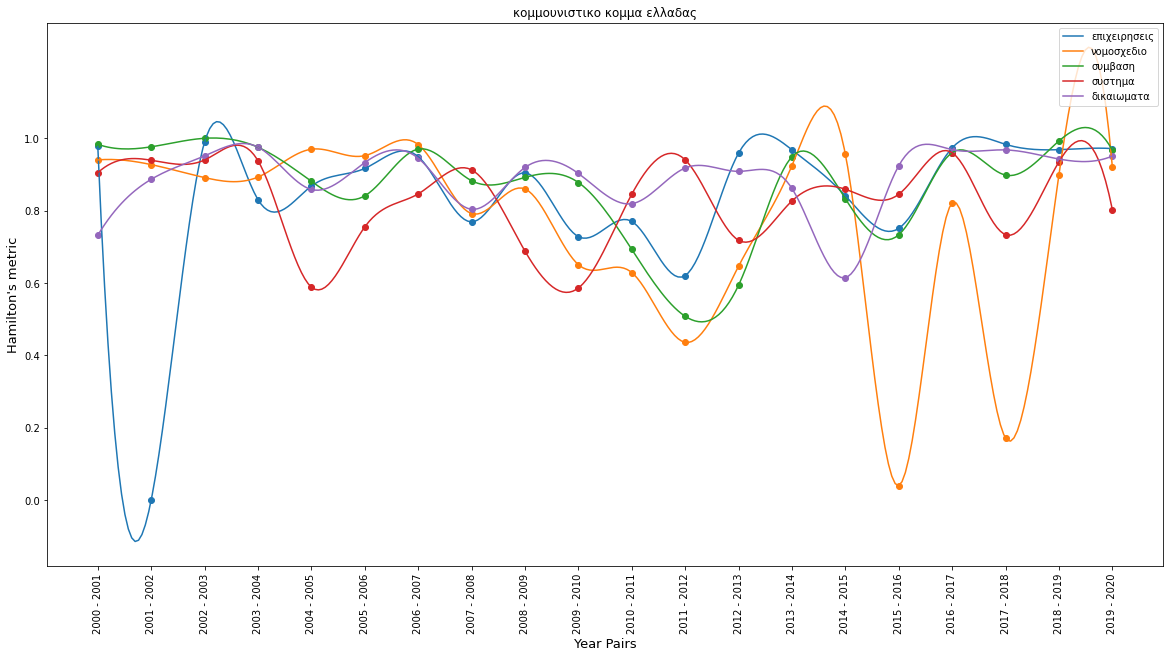

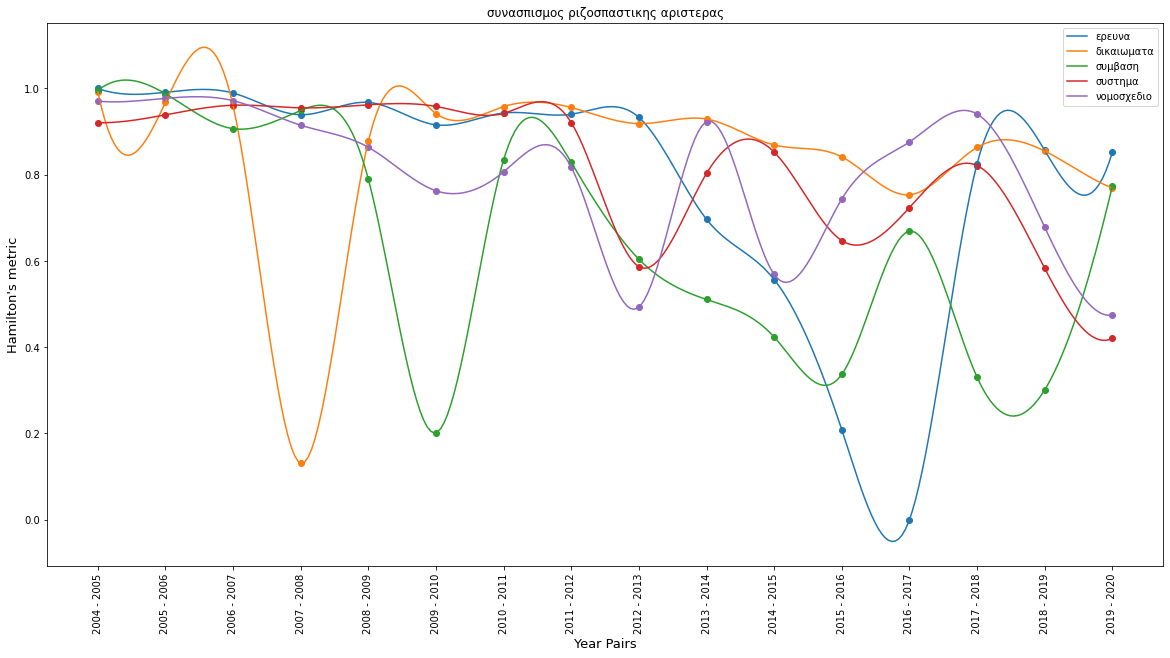

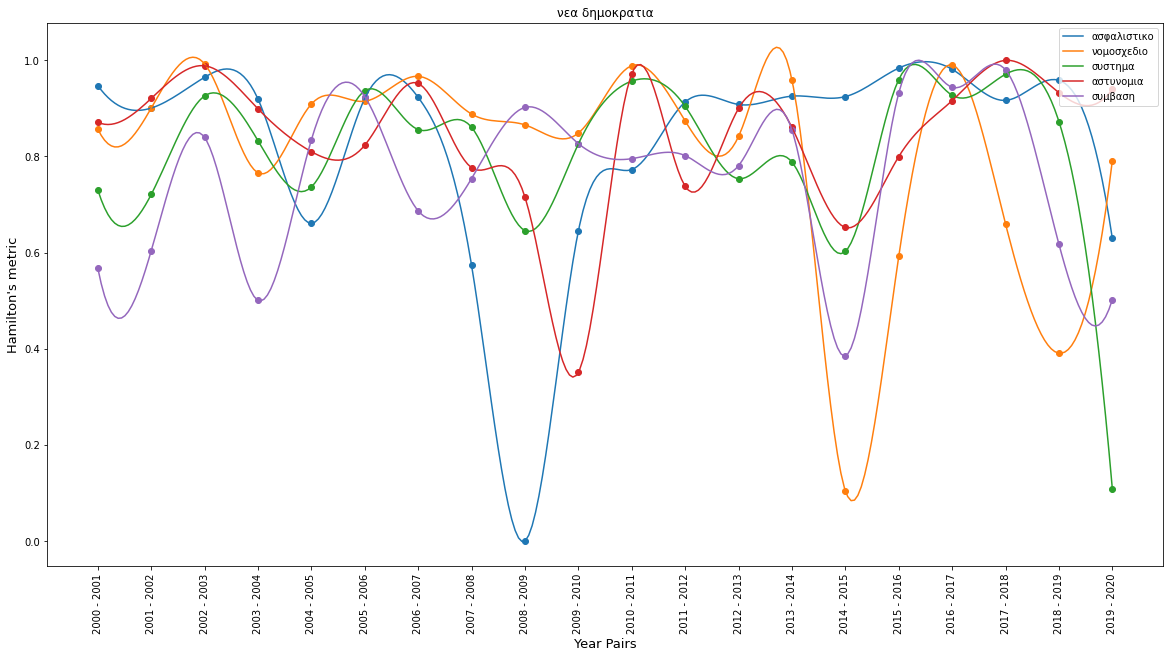

In [212]:
import decimal

all_sims = []
def drange(x, y, jump):
    while x < y:
        yield float(x)
        x += decimal.Decimal(jump)

for party in parties_selected:
    party_sims = []
    for topic_sim in topics_to_plot_dict[party]:
        topic = topic_sim[0]
        df = for_plot_smoothed_all.loc[
            (for_plot_smoothed_all.parties == party) & (for_plot_smoothed_all.topics == topic)].reset_index()
        #print(df)
        #print(topic[0])
        if len(df.all_similarities) == 0:
            continue

        if party == 'πανελληνιο σοσιαλιστικο κινημα':
            similarities = df.all_similarities[0][10:]
            x_values = all_pairs[10:25]
            #x_values = grouped_data.loc[grouped_data.political_party == 'πανελληνιο σοσιαλιστικο κινημα'].year.unique()
        elif party == 'κομμουνιστικο κομμα ελλαδας':
            similarities = df.all_similarities[0][8:] # select sims 8 years after its creation
            x_values = all_pairs[10:]
            #x_values = grouped_data.loc[grouped_data.political_party == 'κομμουνιστικο κομμα ελλαδας'].year.unique()
        elif party == 'συνασπισμος ριζοσπαστικης αριστερας':
            similarities = df.all_similarities[0][:]
            x_values = all_pairs[14:]
            #x_values = grouped_data.loc[grouped_data.political_party == 'συνασπισμος ριζοσπαστικης αριστερας'].year.unique()
        else:
            similarities = df.all_similarities[0][10:]
            #print(len(similarities))
            x_values = all_pairs[10:]
        #similarities = similarities/max(similarities)
        party_sims.extend(similarities)
        all_sims.extend(similarities)
        plt.scatter(x=list(range(len(similarities))), y=similarities)
        #print(df.all_similarities[0][0:5])
        xnew = np.linspace(0, len(similarities)-1, 300)
        #print(party)
        #print(similarities)
        spl = make_interp_spline(range(len(similarities)), similarities, k=3)
        power_smooth = spl(xnew)
        plt.xticks(list(range(len(x_values))), x_values)
        plt.plot(xnew, power_smooth, label = topic)
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right',prop={'size': 10})
    plt.rcParams['figure.figsize'] = (20, 10)
    plt.title(party)
    plt.ylabel('Hamilton\'s metric', fontsize=13)
    plt.xlabel('Year Pairs', fontsize=13)
    plt.xticks(list(range(len(x_values))), x_values)
    step = (max(party_sims)-min(party_sims))/5
    plt.yticks(np.arange(min(party_sims),max(party_sims)+0.01,step), np.round(np.arange(0,1.1,0.2), 1))
    #plt.ylim([-3, 3])
    plt.savefig(f"../cosine_sim_plots/not_aligned_many_topics_one_party-{party}.jpg")
    plt.show()
    plt.close()

In [204]:
list(range(0, 5))

[0, 1, 2, 3, 4]

In [8]:
%%time
original_data = pd.read_csv('../out_files/tell_all_corrected.csv')
original_data['sitting_date'] = pd.to_datetime(data['sitting_date'])
original_data['year'] = original_data['sitting_date'].apply(lambda x: x.year)
original_data.head(3)

CPU times: user 35 s, sys: 1.87 s, total: 36.9 s
Wall time: 41.2 s


member_name sitting_date parliamentary_period  \
0  κρητικος νικολαου παναγιωτης   1989-03-07             period 5   
1  κρητικος νικολαου παναγιωτης   1989-03-07             period 5   
2  κρητικος νικολαου παναγιωτης   1989-03-07             period 5   

  parliamentary_session parliamentary_sitting                 political_party  \
0             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   
1             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   
2             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   

                                     government member_region  \
0  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   
1  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   
2  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   

                                              roles member_gender  \
0  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   
1  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   
2  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   

  speaker_info                                             speech    year  
0   προεδρευων   Παρακαλείται ο Γραμματέας κ. Βουλγαράκης να σ...  1989.0  
1   προεδρευων   Παρακαλείται ο κύριος Γραμματέας να συνοδεύσε...  1989.0  
2   προεδρευων   Κύριοι συνάδελφοι, παρακαλώ τη Βουλή να εξουσ...  1989.0

## Find Some Words' Contexts

In [10]:
print(original_data.loc[(original_data.political_party == 'κομμουνιστικο κομμα ελλαδας')
         & (original_data.speech.str.find('επιχειρήσεις')>=0)
         & (original_data.year == 2001)].speech)

388590     Πράγματι το χρηματιστήριο έγινε μεγάλο κοινων...
389072     Κύριε Πρόεδρε, κυρίες και κύριοι Βουλευτές, ε...
389410     Ευχαριστώ πολύ, κύριε Πρόεδρε. Ευχαριστώ και ...
389875     Κύριε Πρόεδρε, κυρίες και κύριοι Βουλευτές, π...
390469     Κυρίες και κύριοι Βουλευτές, ο σχεδιασμός της...
                                ...                        
436440     Ευχαριστώ, κυρία Πρόεδρε.Κύριοι Βουλευτές, σε...
436508     Κύριε Πρόεδρε, κύριοι συνάδελφοι, ο Κρατικός ...
436578     Ακούγοντας τους εισηγητές της Πλειοψηφίας και...
436867     Η Κυβέρνηση δε χάνει καμιά ευκαιρία για να μη...
437022     Κυρίες και κύριοι Βουλευτές, συμφωνώ με την ε...
Name: speech, Length: 117, dtype: object


In [11]:
print(original_data.loc[(original_data.political_party == 'κομμουνιστικο κομμα ελλαδας')
         & (original_data.speech.str.find(' επιχειρήσεις ')>=0)
         & (original_data.year == 2001)].speech.iloc[1])

 Ευχαριστώ πολύ, κύριε Πρόεδρε. Ευχαριστώ και τοναγαπητό συνάδελφο Υπουργό. Θα σας επισημάνω δύο πράγματα, κύριε Υπουργέ, διότι δεν θα ήθελα να σας απαντήσω ως ατυχήσασα και ιδίως ως ατυχήσασα σε συσχετισμούς.Γνωρίζετε πάρα πολύ καλά την έννοια του ανταποκριτού, άρα γνωρίζετε και την έννοια του πολεμικου ανταποκριτού. 'Αλλωστε το γνωρίζει και η ελληνική πολιτεία. Ουκ ολίγες φορές έχει εντάξει στα πλαίσια πολιτικών, αλλά και στρατιωτικών δραστηριοτήτων της το είδος των δημοσιογράφων που χαρακτηρίζονται πολεμικοί ανταποκριτές. Είτε είναι ατυχής ή όχι ή είναι αποδεκτός από εσάς ή όχι ο χαρακτηρισμός του πολεμικού ανταποκριτή, δηλαδή αυτού που πηγαίνει στα πεδία των μαχών, πολύ φοβούμαι ότι και σε δημοκρατίες και σε καθόλου πολεμικές επιχειρήσεις και σε κάλυψη διαδηλήσεων αλλά και σε πολύ μεγάλους πολέμους και σε πολύ μεγάλα μέτωπα δυστυχώς και ατυχώς -αλλά και δόξα τω Θεώ για το χαρακτηρισμό- το δημοσιογραφικό επάγγελμα αριθμεί μερικές εκατοντάδες νεκρούς παγκοσμίως το χρόνο και έχει αντι

In [12]:
print(original_data.loc[(original_data.political_party == 'κομμουνιστικο κομμα ελλαδας')
         & (original_data.speech.str.find(' επιχειρήσεις ')>=0)
         & (original_data.year == 2002)].speech.iloc[2])

 Ευχαριστώ, κύριε Πρόεδρε. Πάντως θέλω να τονίσω και να σημειώσω ότι η κατάσταση είναι πολύ πιο δραματική απ' όσα αναφέρουμε στην επίκαιρη ερώτηση.Ειλικρινά σας λέω, γιατί το ζω καθημερινά, όταν και όποιες μέρες είμαι στη Λάρισα, κάθε πρωί στον ΟΑΕΔ στοιβάζονται εκατοντάδες άνεργοι οι οποίοι δεν έχουν στον ήλιο μοίρα. Τα στοιχεία που έχει δώσει ο ΟΑΕΔ για τα προηγούμενα χρόνια δείχνουν και το μέγεθος και την πραγματικότητα. Το 1997 οι άνεργοι ήταν οκτώμισι χιλιάδες το 1998 ήταν δεκατρείς χιλιάδες τετρακόσιες το 1999 ήταν δεκαεννέα χιλιάδες εκατό και το 2000 ήταν είκοσι πέντε χιλιάδες. Αυτά είναι στοιχεία του ΟΑΕΔ της Λάρισας. Φέτος δεν μας τα έδωσαν, ακριβώς γιατί έγιναν εκατοντάδες απολύσεις από επιχειρηματίες οι οποίοι θέλουν να τους ξαναπροσλάβουν με την επιδότηση. Θέλω να πω ότι οι περισσότεροι απ' αυτούς τους άνεργους δούλευαν στα κλωστοϋφαντουργία και στον ιματισμό. Επιδοτήθηκαν οι εργοδότες να μεταφέρουν τις επιχειρήσεις σε γειτονικές χώρες με την πολιτική της οικονομικής διείσδ

In [13]:
print(original_data.loc[(original_data.political_party == 'συνασπισμος ριζοσπαστικης αριστερας')
         & (original_data.speech.str.find('έρευνα')>=0)
         & (original_data.year == 2016)].speech)

1043195     Ευχαριστώ, κύριε Πρόεδρε. Όπως γνωρίζετε, ο Κ...
1045016     Το δέχομαι, όπως με διορθώνετε. Είναι «τριάμι...
1045292     Ναι, κύριε Πρόεδρε. Δύο πράγματα θα πω ακόμα....
1045934     Εμείς, όμως, ξέρουμε ότι απέναντι σε αυτόν το...
1047544     Για να κλείσω με την ουσία της ερώτησης, θέλω...
                                 ...                        
1113769     Κύριε Πρόεδρε, κυρίες και κύριοι Βουλευτές, κ...
1113834     Ευχαριστώ, κύριε Πρόεδρε.Κυρίες και κύριοι συ...
1114110     Τα νησιά αυτά, κυρίες και κύριοι συνάδελφοι, ...
1116276     Κύριε Γεωργιάδη, οι αρμόδιοι υπάλληλοι παραλα...
1118031     Όσον αφορά τη φαρμακευτική δαπάνη, πέρυσι ήτα...
Name: speech, Length: 180, dtype: object


In [14]:
print(original_data.loc[(original_data.political_party == 'συνασπισμος ριζοσπαστικης αριστερας')
         & (original_data.speech.str.find('έρευνα')>=0)
         & (original_data.year == 2016)].speech.iloc[2])

 Ναι, κύριε Πρόεδρε. Δύο πράγματα θα πω ακόμα. Όσον αφορά την αριστεία, γίνεται και ξαναγίνεται αυτή η συζήτηση. Ανακυκλώνεται μια εξαιρετικά ασθενής επιχειρηματολογία. Είπε κάτι ο Βουλευτής και απόστρατος Στρατηγός, ο κ. Ντζιμάνης. Θέλω, όμως, να επικαλεστώ την κοινή λογική. Η Νέα Δημοκρατία υποστηρίζει σθεναρά αυτή τη στιγμή έναν νόμο που, αν δεν κάνω λάθος, καταψήφισε στη Βουλή. Ένα ζήτημα είναι αυτό. Εναντιώνεστε σε βαθμολογίες, τις οποίες χρησιμοποιήσατε σαν Νέα Δημοκρατία και δεν τις αλλάξατε. Κι ας πάμε πιο συγκεκριμένα. Θέλω εγώ την αριστεία και στα σχολεία; Βεβαίως, τη θέλω και στις σχολές. Όμως, ένας αξιωματικός ο οποίος έχει μια καριέρα σαράντα χρόνων, έχει μόνο το εξάμηνο και το ενιάμηνο υποχρεωτικό σχολείο; Δεν είναι η επιχειρησιακή και επαγγελματική του κατάρτιση, δεν είναι η διαχείριση προσωπικού, δεν είναι η αποτελεσματικότητά του, οι οποίες τον καθιστούν άριστο; Θέλω να σας πω μια προσωπική γνώμη -δεν θέλω να πω κάτι- και φαντάζομαι θα συμφωνήσετε σε αυτό το πράγμα. Εγ

In [15]:
print(original_data.loc[(original_data.political_party == 'συνασπισμος ριζοσπαστικης αριστερας')
         & (original_data.speech.str.find('έρευνα')>=0)
         & (original_data.year == 2017)].speech.iloc[2])

 Ευχαριστώ, κύριε Πρόεδρε. Καλησπέρα σας.Κυρίες και κύριοι συνάδελφοι, η απόφαση για την συγκρότηση της εξεταστικής επιτροπής υπηρέτησε μια αναγκαιότητα. Ήταν συνεπής προς τη διακηρυγμένη πρόθεση και δέσμευση της Κυβέρνησης να ερευνήσει και να πατάξει τη διαπλοκή, φέρνοντας στο φως όλες τις περιπτώσεις καταχρήσεων, χαριστικών πράξεων, παρανομιών, για τις οποίες έως τότε υπήρχαν μεν πολλές ενδείξεις, δεν είχε όμως σχηματιστεί μια πλήρης και ολοκληρωμένη εικόνα. Το ξερίζωμα της διαπλοκής ήταν, επίσης, και παραμένει βασικό πολιτικό πρόταγμα του ΣΥΡΙΖΑ, βασικό συστατικό του αναγεννητικού του προγράμματος, που το υπηρέτησε και το υπηρετεί με συνέπεια και υπευθυνότητα, έχοντας πάρει γι’ αυτό σαφή εντολή από τον ελληνικό λαό. Η πολύμηνη δουλειά της επιτροπής έφερε στο φως και οδηγεί στη δικαιοσύνη δεκάδες περιπτώσεων, που δεν αποτελούν απλώς ιδιαίτερες και μεμονωμένες χαριστικές δανειακές πράξεις. Αποτελούν μέρος μιας τοιχογραφίας, μιας γιγαντογραφίας, αν θέλετε, του συστήματος πολιτικής και 

In [16]:
print(original_data.loc[(original_data.political_party == 'νεα δημοκρατια')
         & (original_data.speech.str.find('ασφαλιστικό')>=0)
         & (original_data.year == 2008)].speech.iloc[4])

 Με αυτήν την ευκαιρία και επειδή έγινε και αναφορά θεωρώ ότι ήταν εξαιρετικά εποικοδομητική η σημερινή συνάντηση, η οποία έγινε θεσμική συνάντηση στο Υπουργείο Απασχόλησης, των γυναικών Βουλευτών ακριβώς για τα θέματα που αφορούν στη γυναικεία απασχόληση και στα μέτρα εκείνα και τους όρους που πρέπει να διαμορφωθούν, ώστε να προχωρήσουμε στη συμφιλίωση ανάμεσα στην οικογενειακή και στην επαγγελματική ζωή των γυναικών, όπως επίσης και στα θέματα των δικαιωμάτων των γυναικών και βεβαίως την πραγματική υλοποίηση στην πράξη της πραγματικής ισότητας των ευκαιριών των γυναικών στην αγορά εργασίας και την προστασία της μητρότητας. Βεβαίως, κύριε Πρόεδρε, επειδή αναφερθήκατε και ήθελα να το πω στους συναδέλφους, η όποια πολιτική απόφαση ελήφθη από το ΠΑ.ΣΟ.Κ. και από τα κόμματα της Αριστεράς είναι δικαίωμά σας, όμως λυπάμαι πραγματικά ως γυναίκα Βουλευτής που έχω θητεύσει για πολλά χρόνια εδώ –είμαι από τις πρώτες γυναίκες Βουλευτές- για ένα λόγο, διότι αντιμετωπίσατε και προσεγγίσατε ένα τόσ

In [19]:
print(original_data.loc[(original_data.political_party == 'νεα δημοκρατια')
         & (original_data.speech.str.find('ασφαλιστικό')>=0)
         & (original_data.year == 2009)].speech.iloc[0])

 Ευχαριστώ πολύ, κυρία Πρόεδρε. Να ευχηθώ και εγώ σε όλους «Χρόνια Πολλά», «Καλή Χρονιά» και μακάρι ο καινούριος χρόνος να είναι χρόνος δημιουργικός και ειρηνικός. Θα ήθελα να απευθύνω, επίσης, μία ιδιαίτερη έκκληση να σταθούμε περισσότερο σ’ αυτά τα πολλά που πραγματικά μας ενώνουν, εάν θέλετε, στο χώρο της υγείας και να σφυρηλατήσουμε τη σχέση και τη συζήτηση και την προσπάθεια πάνω σ’ αυτά και να απομονώσουμε τα πολύ λιγότερα που μας χωρίζουν. Δεν θα έλεγε ποτέ κανείς ότι ανάμεσα στις πολιτικές δυνάμεις, στα πολιτικά κόμματα, στις συζητήσεις στο Κοινοβούλιο η ιδεολογική αφετηρία και τοποθέτηση του καθενός μπορεί να περάσει σε δεύτερη μοίρα και τα υπόλοιπα στοιχεία να κυριαρχήσουν. Σε καμμία περίπτωση! Όμως, υπάρχουν πάρα πολλά στοιχεία τα οποία μπορούμε να αναδείξουμε -όπου κι αν ανήκει ο καθένας- και αυτή η ανάδειξη να οδηγήσει στην προώθηση και στην επίλυση και να μην γίνεται ανάδειξη προβλημάτων μόνο για την ανάδειξη, που πολλές φορές οδηγεί σε διαστρεβλωμένη ανάδειξη των προβλημ

In [20]:
print(original_data.loc[(original_data.political_party == 'πανελληνιο σοσιαλιστικο κινημα')
         & (original_data.speech.str.find('σύστημα')>=0)
         & (original_data.year == 2011)].speech.iloc[2])

 Αυτό είναι το βάρος του παρελθόντος που παραλάβαμε και για την ακρίβεια –για να είμαι απολύτως σαφής- που παρέλαβα. Πώς εξυπηρετείται το δημόσιο συμφέρον; Θεσπίζεται ένα σαφώς βελτιωμένο και λειτουργικό σύστημα επιστροφών, ώστε να αντιμετωπίζεται αποτελεσματικά το φαινόμενο της παράνομης εισόδου και της παραμονής των αλλοδαπών στην Ελλάδα με την καθιέρωση δίκαιης και διαφανούς διαδικασίας με ειδική μέριμνα για την προστασία των δικαιωμάτων των αλλοδαπών, όπως προβλέπεται από τις διεθνείς υποχρεώσεις της χώρας. Σε κάθε περίπτωση, λαμβάνονται υπ’ όψιν τα πραγματικά δεδομένα, όπως έχουν διαμορφωθεί και πάνω απ’ όλα και πρώτα απ’ όλα το δημόσιο συμφέρον. Η πρόθεση της πολιτικής ηγεσίας του Υπουργείου μας, του Υφυπουργού Μανώλη Όθωνα και της δικής μου προσωπικά, είναι η αντιμετώπιση των μεικτών μεταναστευτικών ροών στα σημεία εισόδου της ελληνικής επικράτειας με τρόπο που να διασφαλίζει τόσο την ανάγκη ελέγχου των συνόρων απέναντι στην παράνομη μετανάστευση όσο και την ανάγκη παροχής προστ

In [21]:
print(original_data.loc[(original_data.political_party == 'πανελληνιο σοσιαλιστικο κινημα')
         & (original_data.speech.str.find('σύστημα')>=0)
         & (original_data.year == 2012)].speech.iloc[3])

 Ευχαριστώ, κύριε Πρόεδρε.Θα ήθελα κατ’ αρχάς να ξεκινήσω με μια έκκληση προς την πολιτική ηγεσία του Υπουργείου Αγροτικής Ανάπτυξης και Τροφίμων με αφορμή μία τροπολογία, που έχει κατατεθεί με διακομματική πρωτοβουλία κάποιων Βουλευτών, και απ’ ό,τι αντιλαμβάνομαι, με τον ανάλογο συναινετικό οίστρο. Πρόκειται για την τροπολογία που ουσιαστικά απαλλάσσει από κάθε αστική και ποινική ευθύνη τα μέλη των διοικητικών συμβουλίων αγροτικών συλλόγων και ενώσεων αγροτικών συνεταιρισμών, προκειμένου σύμφωνα με την τροπολογία, η οποία ασφαλώς δεν δεσμεύει την πολιτική ηγεσία του Υπουργείου Αγροτικής Ανάπτυξης, να προχωρήσει ο πράγματι θετικός νόμος για τις νέες συνεταιριστικές οργανώσεις, ο ν.4015/2011.Ζητώ από την πολιτική ηγεσία του Υπουργείου Αγροτικής Ανάπτυξης και ιδιαίτερα από τον Υπουργό κ. Σκανδαλίδη, να μην κάνει δεκτή αυτήν την τροπολογία. Ζητώ, επίσης, από τους συναδέλφους που υπέβαλαν αυτήν την τροπολογία, να μας φέρουν στη Διαρκή Επιτροπή Παραγωγής και Εμπορίου όλα τα στοιχεία των τε

### Words Frequency

In [ ]:
topics_dict

In [209]:
def word_frequency_per_party(party):
    years = list(grouped_data.year.unique())

    for topic_sim in topics_to_plot_dict[party]:
        topic = topic_sim[0]
        topic_sims = []
        x_values = []
        for year in years:
            x_values.append(year)
            try:
                model = Word2Vec.load(f"../wordmodels_cleaned/PERperiod_PERparty/{party}_period{year}.mdl")
                topic_sims.append(model.wv.vocab[topic].count)
                #print(model.wv.vocab[topic].count)
            except:
                topic_sims.append(0)

        if not topic_sims:
            continue
        plt.scatter(x=list(range(len(topic_sims))), y=topic_sims)
        #print(df.all_similarities[0][0:5])
        xnew = np.linspace(0, len(topic_sims)-1, 300)
        spl = make_interp_spline(range(len(topic_sims)), topic_sims, k=3)
        power_smooth = spl(xnew)
        #plt.xticks(list(range(len(x_values))), x_values)
        plt.plot(xnew, power_smooth, label = topic)
        plt.xticks(rotation=90)
        plt.legend(bbox_to_anchor=(1, 1), loc='upper right',prop={'size': 10})
        plt.rcParams['figure.figsize'] = (20, 10)
        plt.title(party)
        plt.ylabel('Word Frequency', fontsize=13)
        plt.xlabel('Year Pairs', fontsize=13)
        plt.xticks(list(range(len(x_values))), x_values)
        #plt.ylim([-3, 3])
        plt.savefig(f"../cosine_sim_plots/word_frequency-{party}-{topic}.jpg")
        plt.show()
        plt.close()

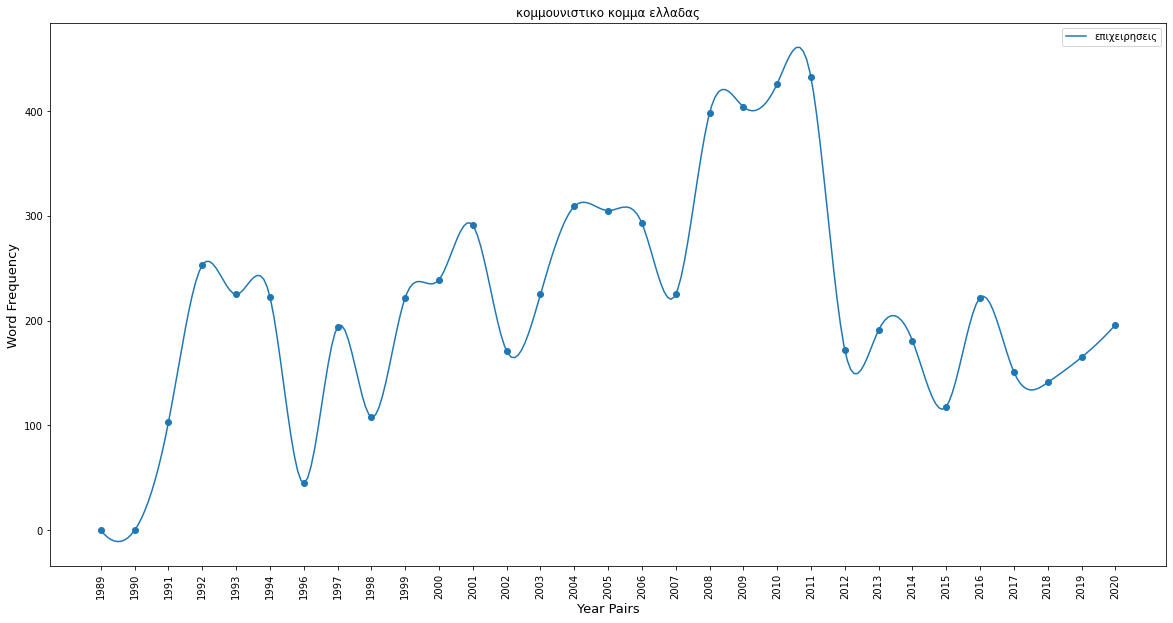

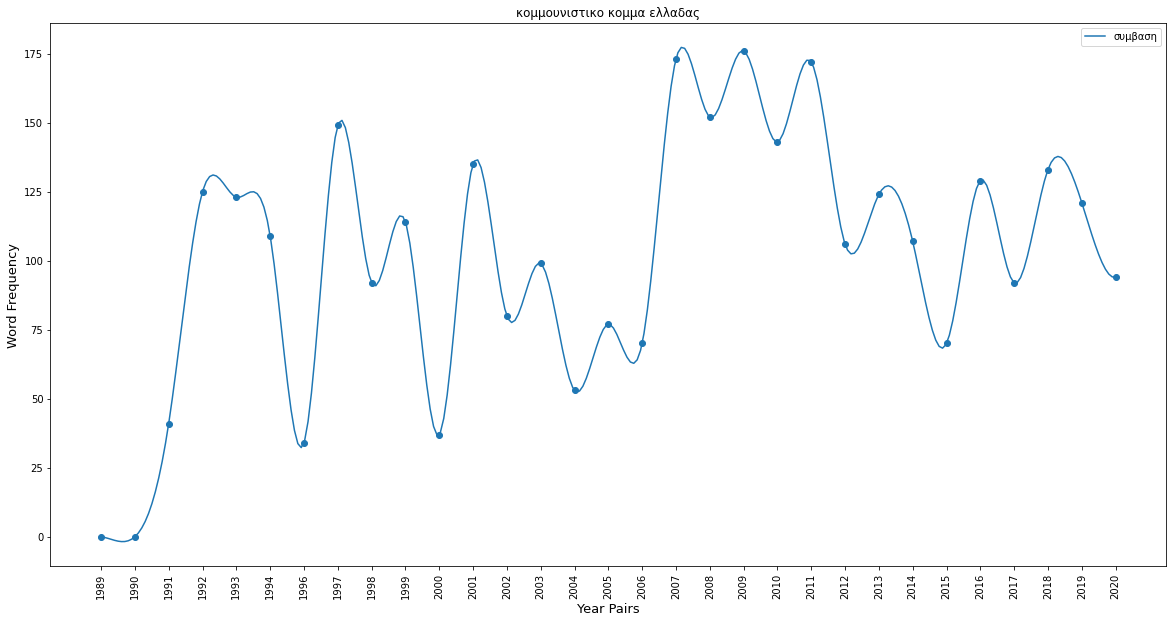

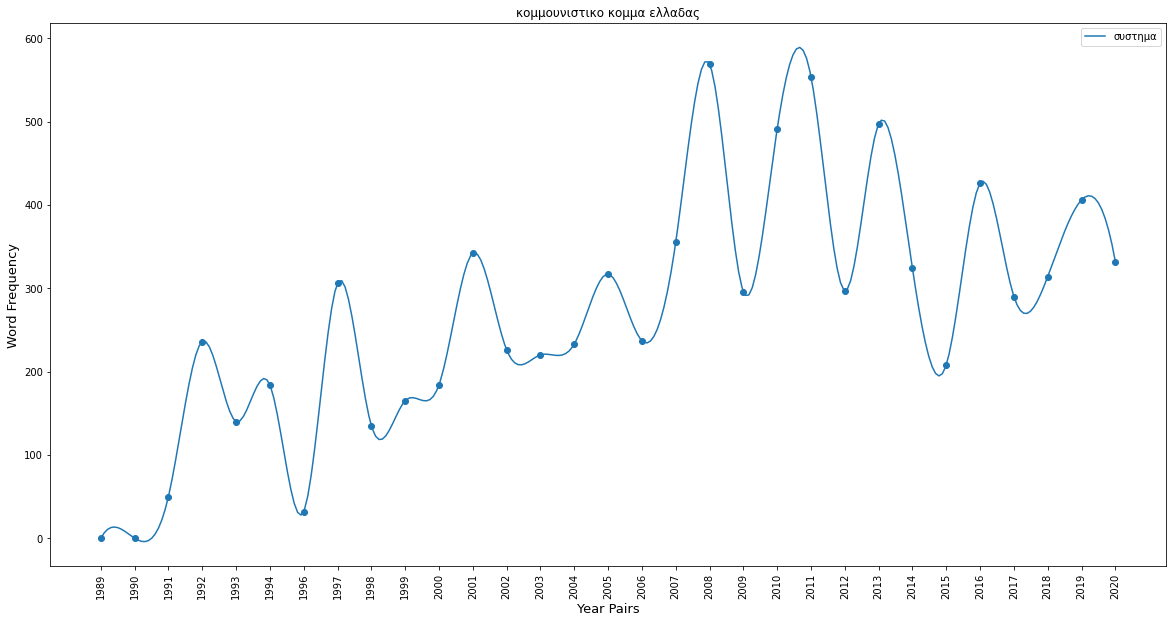

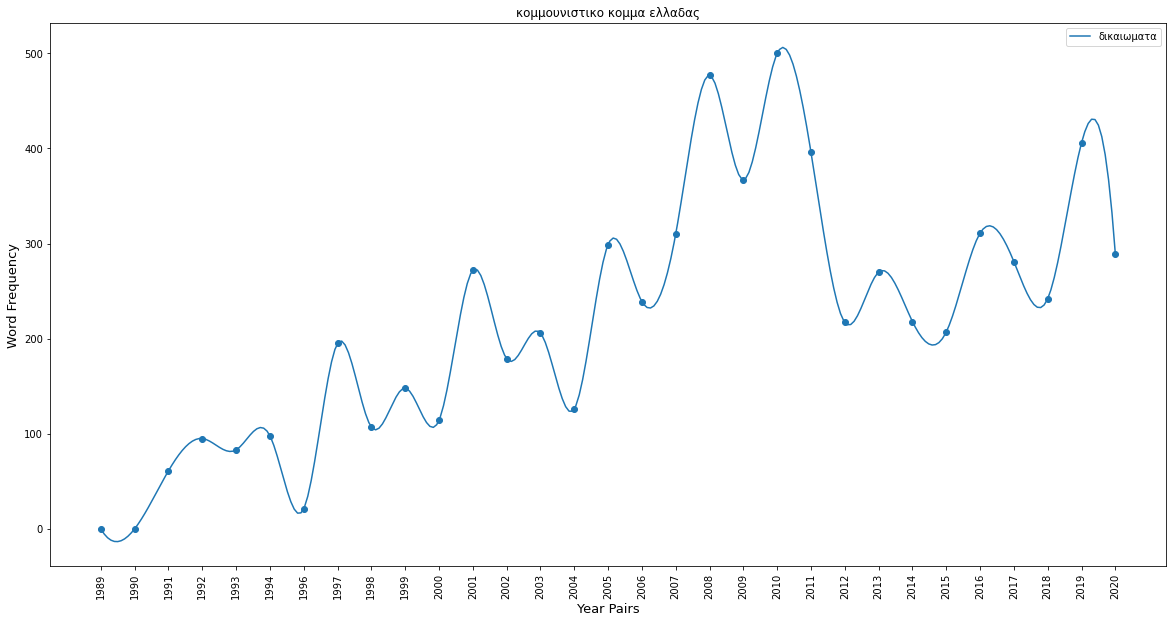

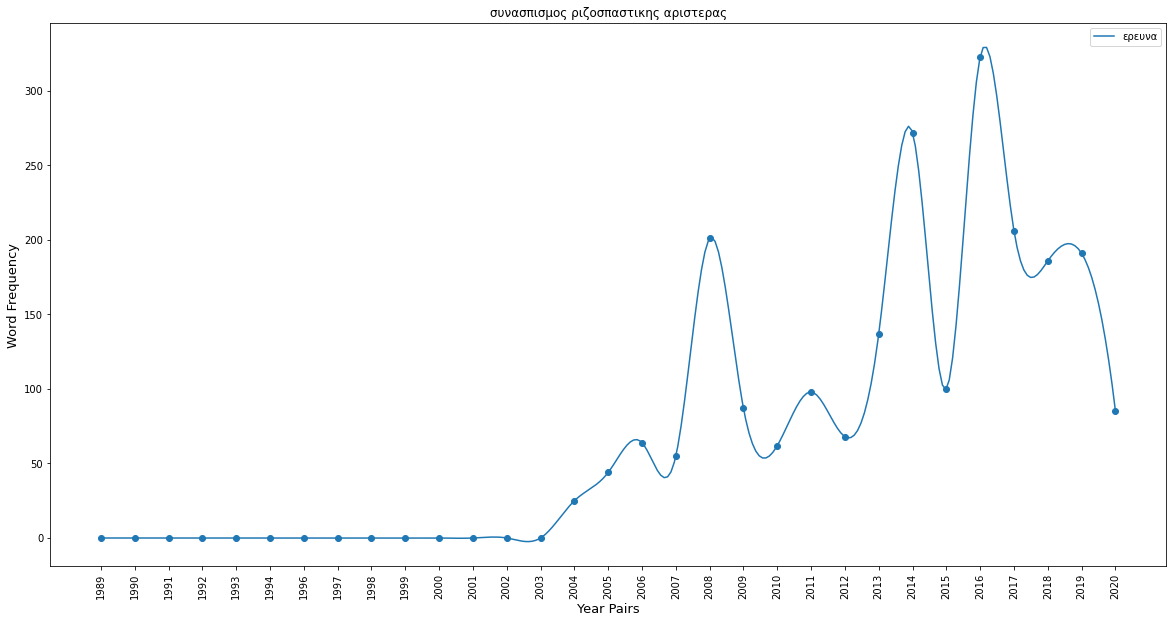

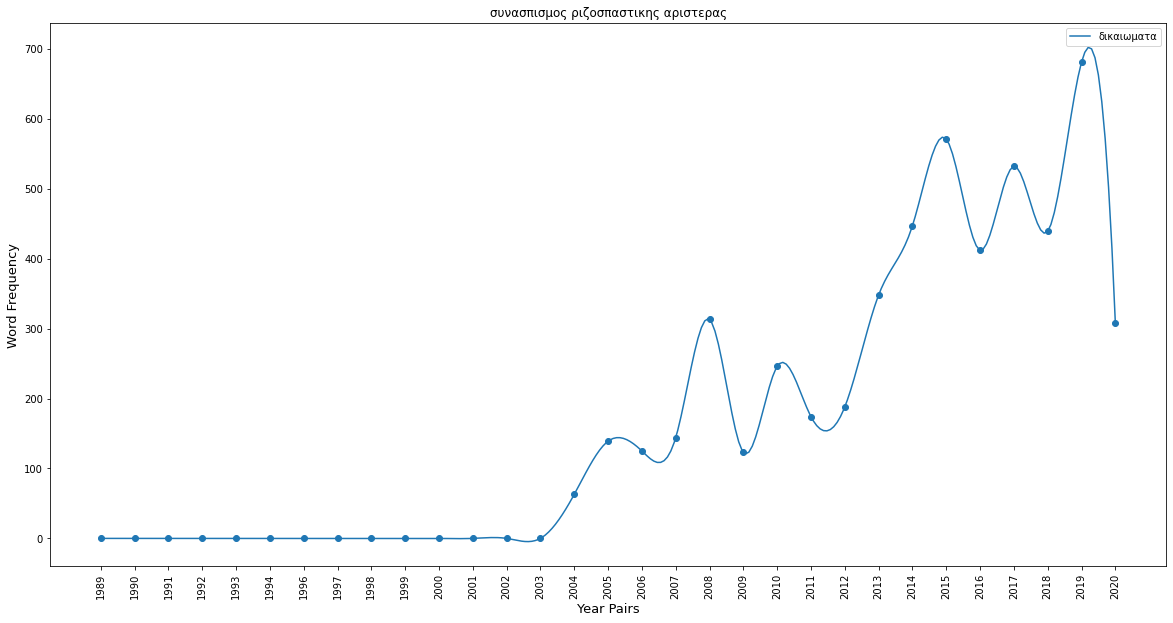

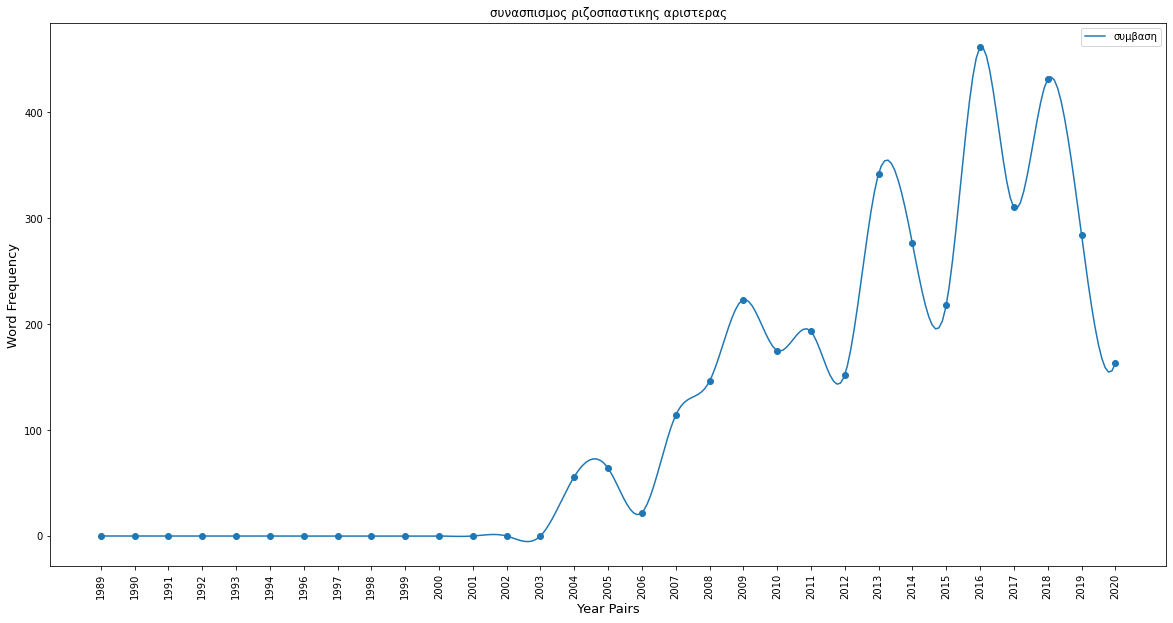

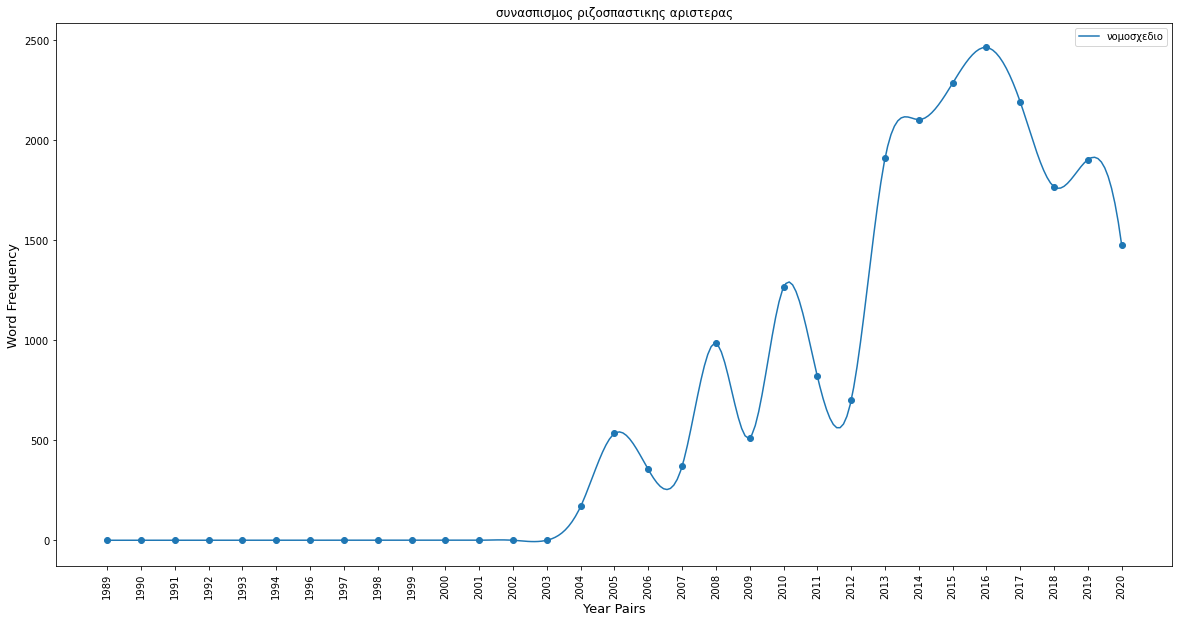

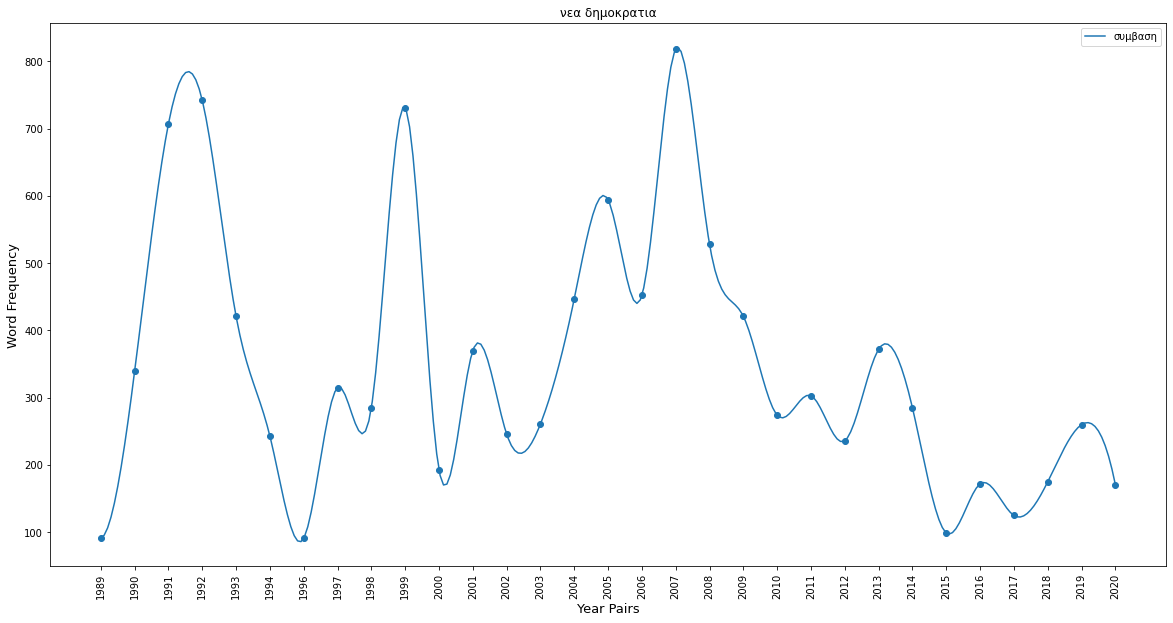

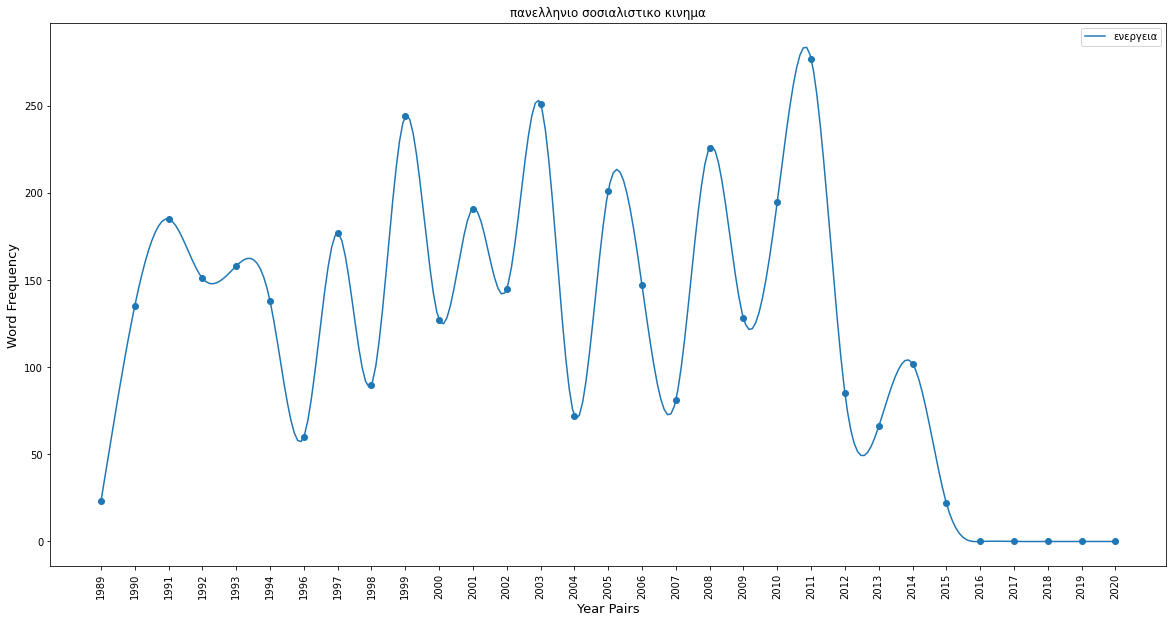

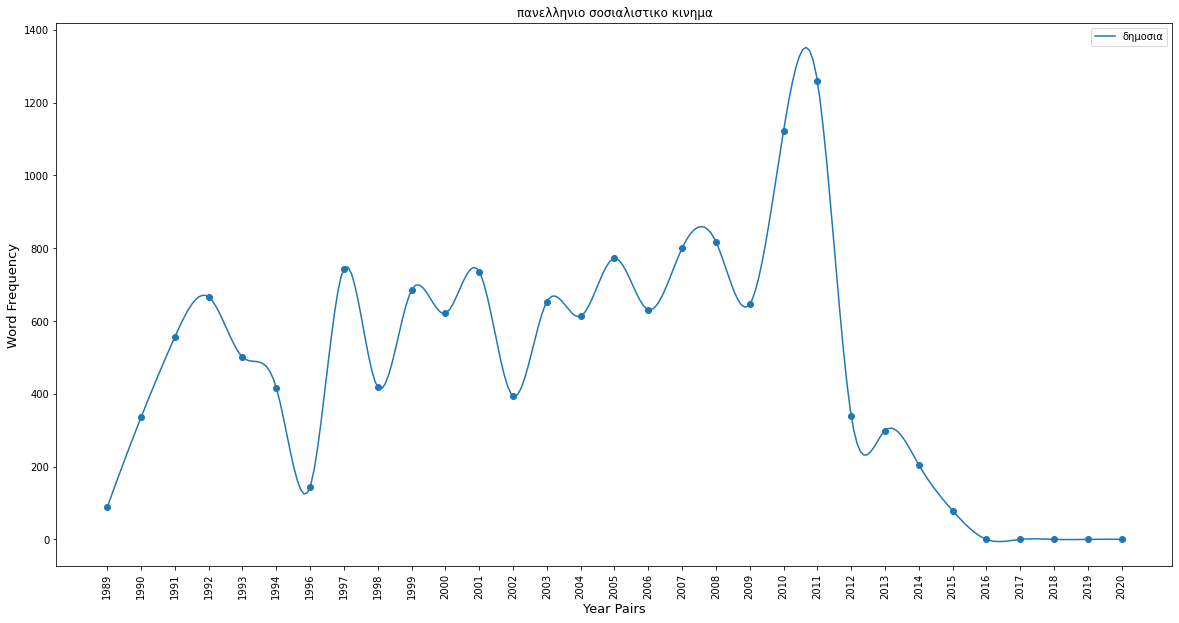

In [210]:
for party in parties_selected:
    word_frequency_per_party(party)

In [ ]:
max(data.loc[data.political_party=='πανελληνιο σοσιαλιστικο κινημα'].year.unique())

### Explore Topics' Top Nearest Neighbours

In [26]:
m1 = Word2Vec.load(f"model/συνασπισμος ριζοσπαστικης αριστερας2016.model")
m2 = Word2Vec.load(f"model/συνασπισμος ριζοσπαστικης αριστερας2017.model")
neighbors_t1 = [w for w,s in m1.wv.most_similar(positive=['ερευνα'], topn=10)]
neighbors_t2 = [w for w,s in m2.wv.most_similar(positive=['ερευνα'], topn=10)]
print(neighbors_t1)
print(neighbors_t2)

['καινοτομια', 'τεχνολογικη', 'εξωστρεφεια', 'προωθει', 'φιλοσοφια', 'αναπτυξιακα', 'αναπτυξιακη', 'συγχρονη', 'επιστημονικη', 'ερευνητικη']
['επιστημονικη', 'προσφορα', 'διαχειριστικη', 'πληροφοριακα', 'ερευνητικη', 'κεντρικη', 'τεκμηριωση', 'ενημερωση', 'διαστημικη', 'τεκμηριωμενη']


In [27]:
m1 = Word2Vec.load(f"model/πανελληνιο σοσιαλιστικο κινημα2011.model")
m2 = Word2Vec.load(f"model/πανελληνιο σοσιαλιστικο κινημα2012.model")
neighbors_t1 = [w for w,s in m1.wv.most_similar(positive=['συστημα'], topn=10)]
neighbors_t2 = [w for w,s in m2.wv.most_similar(positive=['συστημα'], topn=10)]
print(neighbors_t1)
print(neighbors_t2)

['απορρητο', 'κατεστημενο', 'συστημα@sw', 'χωρο', 'σκηνικο', 'οργανισμο', 'τοπιο', 'συστηματος', 'μοντελο', 'μηχανισμο']
['φασμα', 'διαβατηριο', 'βιβλιαριο', 'δογμα', 'συνταγολογιο', 'ορθιο', 'επιπεδο', 'συνταγογραφησης', 'εισιτηριο', 'πρωτοκολλα']


In [25]:
m1 = Word2Vec.load(f"model/κομμουνιστικο κομμα ελλαδας2001.model")
m2 = Word2Vec.load(f"model/κομμουνιστικο κομμα ελλαδας2002.model")
neighbors_t1 = [w for w,s in m1.wv.most_similar(positive=['επιχειρησεις'], topn=10)]
neighbors_t2 = [w for w,s in m2.wv.most_similar(positive=['επιχειρησεις'], topn=10)]
print(neighbors_t1)
print(neighbors_t2)

['τραπεζες', 'επιχειρηματιες', 'μεγαλες', 'εταιρειες', 'μικρες', 'εταιριες', 'κερδη', 'ιδιωτικες', 'πολυεθνικες', 'κεφαλαια']
['μικρες', 'ξενες', 'ιδιωτες', 'μεγαλες', 'επιχειρηματιες', 'εταιρειες', 'εταιριες', 'επενδυσεις', 'ανταγωνισμο', 'τραπεζες']


In [28]:
m1 = Word2Vec.load(f"model/νεα δημοκρατια2008.model")
m2 = Word2Vec.load(f"model/νεα δημοκρατια2009.model")
neighbors_t1 = [w for w,s in m1.wv.most_similar(positive=['ασφαλιστικο'], topn=10)]
neighbors_t2 = [w for w,s in m2.wv.most_similar(positive=['ασφαλιστικο'], topn=10)]
print(neighbors_t1)
print(neighbors_t2)

['ασφαλιστικου', 'βιωσιμο', 'φορολογικο', 'φερνουμε', 'εκλογικο', 'ψηφισμενο', 'εφερνε', 'λυνει', 'δαιδαλωδες', 'καταρρευσει']
['λειτουργικο', 'τραπεζικο', 'χρηματοπιστωτικο', 'σωφρονιστικο', 'ιδιοτυπο', 'αναρχο', 'φορολογικο', 'προαγωγων', 'εφεδρειας', 'διπλογραφικο']
